## Packages

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import os
from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries
from sunpy.timeseries.sources.goes import XRSTimeSeries
import astropy.units as u
from sunkit_instruments.goes_xrs import calculate_temperature_em
import matplotlib.pyplot as plt
import numpy as np
from sunpy.data import manager
import netCDF4 as nc
import os
import pandas as pd
from datetime import datetime, timedelta
import copy
from matplotlib import colormaps
list(colormaps)
#from colorspacious import cspace_converter
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterMathtext
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob

## Funciones gráficas

In [2]:

# Plot with ticks every minute
def plot_fai_and_flare_lines(df_combined, df_fai_selected, df_fai_all, df_flare_data, 
                              flare_start_time, flare_end_time, graphics_dir,
                              ymin=1e-9, ymax=1e-4):
    """
    Plots XRS A and B on a logarithmic scale with vertical lines for FAI events and flare times.
    df_fai_all: all candidate FAI events
    df_fai_selected: FAI events selected by a method
    """
    import matplotlib.dates as mdates
    import os
    
    # Ensure time types
    flare_start_time = pd.to_datetime(flare_start_time)
    flare_end_time = pd.to_datetime(flare_end_time)
    
    print(f"Buscando datos entre: {flare_start_time} y {flare_end_time}")

    # Convert date columns to datetime if they aren't already
    df_combined['date'] = pd.to_datetime(df_combined['date'])
    df_fai_selected['date'] = pd.to_datetime(df_fai_selected['date'])
    df_fai_all['date'] = pd.to_datetime(df_fai_all['date'])
    df_flare_data['StartTime'] = pd.to_datetime(df_flare_data['StartTime'])
    df_flare_data['PeakTime'] = pd.to_datetime(df_flare_data['PeakTime'])
    df_flare_data['EndTime'] = pd.to_datetime(df_flare_data['EndTime'])

    # DEBUG: Verificar rangos de fechas en los dataframes
    print(f"Rango df_combined: {df_combined['date'].min()} a {df_combined['date'].max()}")
    print(f"Rango df_fai_selected: {df_fai_selected['date'].min()} a {df_fai_selected['date'].max()}")
    print(f"Rango df_flare_data PeakTime: {df_flare_data['PeakTime'].min()} a {df_flare_data['PeakTime'].max()}")

    # Filter data based on date column - método más robusto
    mask_combined = (df_combined['date'] >= flare_start_time) & (df_combined['date'] <= flare_end_time)
    df_plot = df_combined.loc[mask_combined].copy()
    
    mask_fai = (df_fai_selected['date'] >= flare_start_time) & (df_fai_selected['date'] <= flare_end_time)
    df_fai_interval = df_fai_selected.loc[mask_fai].copy()

    mask_fai_all = (df_fai_all['date'] >= flare_start_time) & (df_fai_all['date'] <= flare_end_time)
    df_fai_all_interval = df_fai_all.loc[mask_fai_all].copy()


    # DEBUG: Verificar cuántos datos encontramos
    print(f"Datos en df_plot: {len(df_plot)}")
    print(f"Datos en df_fai_interval: {len(df_fai_interval)}")

    # Si no hay datos en el rango, mostrar advertencia
    if len(df_plot) == 0:
        print(f"¡ADVERTENCIA! No hay datos en df_combined para el rango {flare_start_time} a {flare_end_time}")
        return

    plt.rcParams.update({
        "axes.titlesize": 16, "axes.labelsize": 16, 
        "xtick.labelsize": 15, "ytick.labelsize": 15, 
        "legend.fontsize": 13
    })

    # Create figure
    fig, ax = plt.subplots(figsize=(13, 5))

    # Plot XRS A and B usando el índice numérico para evitar problemas con fechas
    x_vals = range(len(df_plot))  # Usar índice numérico para el plotting
    ax.plot(x_vals, df_plot['xrsa'], label='XRS A', color='blue', linewidth=1)
    ax.plot(x_vals, df_plot['xrsb'], label='XRS B', color='red', linewidth=1)

    # Log scale and Y-axis limits
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel('X-ray Flux [W/m²]')
    ax.set_xlabel(f"Time [UTC] – {flare_start_time:%d %b %Y}")
    ax.set_title(f'XRS A and B with FAI and Flare Times\n{flare_start_time:%Y-%m-%d %H:%M} to {flare_end_time:%H:%M}')
    ax.grid(True, alpha=0.3)
    
    # -----------------------
    # Configure X axis ticks
    # -----------------------
    # Crear un array de minutos dentro del intervalo de flare
    start_time = flare_start_time
    end_time = flare_end_time

    # Generar ticks mayores cada 10 minutos
    major_times = pd.date_range(start=start_time.ceil('10min'), end=end_time, freq='10min')
    major_indices = [(np.abs(df_plot['date'] - t)).argmin() for t in major_times]
    major_labels = [t.strftime('%H:%M') for t in major_times]

    # Generar ticks menores cada 1 minuto
    minor_times = pd.date_range(start=start_time.ceil('1min'), end=end_time, freq='1min')
    minor_indices = [(np.abs(df_plot['date'] - t)).argmin() for t in minor_times]

    # Asignar ticks al eje X
    ax.set_xticks(major_indices)
    ax.set_xticklabels(major_labels)
    ax.set_xticks(minor_indices, minor=True)  # minor ticks sin etiquetas
    

    # -----------------------
    # Plot all FAI candidates (background)
    # -----------------------
    for i, fai_time in enumerate(df_fai_all_interval['date']):
        idx = (np.abs(df_plot['date'] - fai_time)).argmin()
        ax.axvline(x=idx, color='#FF69B4', linestyle='-', linewidth=1.5, alpha=0.7,
                   label='FAI Candidate' if i == 0 else "")


    # Red vertical lines: FAI events
    for fai_time in df_fai_interval['date']:
        # Encontrar la posición en el plot para este tiempo FAI
        time_diff = np.abs(df_plot['date'] - fai_time)
        if len(time_diff) > 0:
            idx = time_diff.argmin()
            ax.axvline(x=idx, color='red', linestyle='-', linewidth=1.5, alpha=0.7,
                      label='FAI Alert' if fai_time == df_fai_interval['date'].iloc[0] else "")

    # Encontrar fulguraciones en el intervalo de tiempo
    flares_in_interval = df_flare_data[
        (df_flare_data['PeakTime'] >= flare_start_time) & 
        (df_flare_data['PeakTime'] <= flare_end_time)
    ]
    
    print(f"Fulguraciones encontradas en el intervalo: {len(flares_in_interval)}")

    # Colores y estilos para los diferentes tiempos de las fulguraciones
    for idx, (_, row) in enumerate(flares_in_interval.iterrows()):
        start_time = row['StartTime']
        peak_time = row['PeakTime']
        end_time = row['EndTime']
        flare_class = row.get('Class', '')
        
        # Función para encontrar la posición en el plot
        def find_time_position(time_val):
            time_diff = np.abs(df_plot['date'] - time_val)
            if len(time_diff) > 0:
                return time_diff.argmin()
            return None
        
        # Línea verde punteada para StartTime
        if flare_start_time <= start_time <= flare_end_time:
            start_pos = find_time_position(start_time)
            if start_pos is not None:
                ax.axvline(x=start_pos, color='green', linestyle=(0, (5, 3)), linewidth=2, alpha=0.8,
                          label='Flare Start' if idx == 0 else "")
        
        # Línea azul discontinua para PeakTime
        if flare_start_time <= peak_time <= flare_end_time:
            peak_pos = find_time_position(peak_time)
            if peak_pos is not None:
                #ax.axvline(x=peak_pos, color='blue', linestyle='--', linewidth=2, alpha=0.8,
                ax.axvline(x=peak_pos, color='blue', linestyle=(0, (5, 3)), linewidth=2, alpha=0.8,
                          label='Flare Peak' if idx == 0 else "")
                
                # AÑADIR FLECHA QUE SEÑALA EL PEAK
                # Encontrar el valor de flujo en el peak time
                peak_flux = None
                peak_time_diff = np.abs(df_plot['date'] - peak_time)
                if len(peak_time_diff) > 0:
                    peak_idx = peak_time_diff.argmin()
                    # Usar el mayor flujo entre XRS A y XRS B
                    peak_flux = max(df_plot['xrsa'].iloc[peak_idx], df_plot['xrsb'].iloc[peak_idx])
                

        
        # Línea amarilla punteada para EndTime
        if flare_start_time <= end_time <= flare_end_time:
            end_pos = find_time_position(end_time)
            if end_pos is not None:
                ax.axvline(x=end_pos, color='orange', linestyle='--', linewidth=3, alpha=0.8,
                          label='Flare End' if idx == 0 else "")
        
        # Anotación con la clase de la fulguración Y FLECHA
        if flare_class and (flare_start_time <= peak_time <= flare_end_time):
            peak_pos = find_time_position(peak_time)
            if peak_pos is not None:
                ax.annotate(flare_class,
                            xy=(peak_pos, ymin * 5),  # Punto destino
                            xytext=(peak_pos + 1, ymin * 15),  # Punto origen (más a la derecha y arriba)
                            fontsize=9,
                            color='darkblue',
                            rotation=0,
                            ha='left',
                            va='center',
                            bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="darkblue", lw=1, alpha=0.8),
                            arrowprops=dict(arrowstyle='->',  # Flecha
                                          color='darkblue',
                                          lw=1,
                                          alpha=0.7,
                                          shrinkA=5,  # Espacio en el origen
                                          shrinkB=0))  # Sin espacio en el destino

    # Final layout with proper legend handling
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")
    

    fig.tight_layout()

    # Create graphics directory if it doesn't exist
    #graphics_dir = "graphics"
    #os.makedirs(graphics_dir, exist_ok=True)

    #en esta función se recibe el directorio como parámetro
    
    output_name = f"FAI_{flare_start_time:%Y%m%d_%H%M}_{flare_end_time:%H%M}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()




#gráfica ce flux vs EM y T
def plot_xrs_vs_te_simple(days, 
                         df_full_valid, 
                         df_flares_valid, 
                         time_column="PeakTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by=None,
                         palette="viridis",  
                         class_to_color=None):
    """
    Versión simplificada que asume que podemos hacer merge por tiempo
    """
    
    # Convertir a datetime
    df_full_valid['date'] = pd.to_datetime(df_full_valid['date'])
    df_flares_valid[time_column] = pd.to_datetime(df_flares_valid[time_column])
    
    # Hacer merge de los dataframes
    df_merged = pd.merge(df_flares_valid, df_full_valid, 
                        left_on=time_column, 
                        right_on='date', 
                        how='inner')
    
    if len(df_merged) == 0:
        print("No hay coincidencias entre los dataframes.")
        return
    
    # Filtrar datos válidos
    valid_data = df_merged.dropna(subset=[XRS, T, EM])
    
    if len(valid_data) == 0:
        print("No hay datos válidos después de filtrar NaNs.")
        return
    
    print(f"Datos válidos para graficar: {len(valid_data)}")
    
    # Preparar datos
    xrs_vals = valid_data[XRS].values
    em_vals = valid_data[EM].values
    t_vals = valid_data[T].values
    
    # Preparar labels para colores
    if color_by == "Class":
        flare_labels = valid_data["Class"].astype(str).str[0].tolist()  # solo letra B,C,M,X
    elif color_by == "Date":
        flare_labels = valid_data[time_column].dt.date.astype(str).tolist()
    elif color_by == "observatory":
        flare_labels = valid_data["observatory"].fillna("Unknown").tolist()
    else:
        flare_labels = [""] * len(valid_data)

    # --- Colores según selección ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # Configuración de plot
    plt.rcParams.update({
        "axes.titlesize": 17, "axes.labelsize": 15,
        "xtick.labelsize": 16, "ytick.labelsize": 16,
        "legend.fontsize": 16
    })

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    # XRS vs EM
    axes[0].scatter(em_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[0].set_xlabel(rf"EM$_{{49}}$ [cm$^{{-3}}$]")
    axes[0].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[0].set_title(f"X-ray flux vs Emission Measure\n{days} days ({time_column})", pad=20)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlim(0.001, None)
    
    # XRS vs T
    axes[1].scatter(t_vals, xrs_vals, c=colors, alpha=0.7, s=50)
    axes[1].set_xlabel(f"T [MK]")
    axes[1].set_ylabel(rf"{XRS} [W/m$^2$]")
    axes[1].set_title(f"X-ray flux vs Temperature\n{days} days ({time_column})", pad=20)
    axes[1].set_xscale("linear")
    axes[1].set_yscale("log")
    axes[1].set_xlim(0, 30)

    # Leyenda
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                             label=str(lab), markersize=12) for lab in labels]
        
        n_labels = len(labels)

        # Obtener posición de los subplots combinados (en coordenadas de la figura)
        pos0 = axes[0].get_position()
        pos1 = axes[1].get_position()
        subplot_left = pos0.x0
        subplot_right = pos1.x1
        subplot_width = subplot_right - subplot_left
        
        # Número de columnas dinámico según ancho de subplots
        items_per_row = max(1, int(subplot_width * 12))  # escala arbitraria, ajustar si se quiere
        ncol = min(n_labels, items_per_row)
        n_rows = int(np.ceil(n_labels / ncol))

        fig.legend(handles=handles, title=color_by,
                  loc="upper center", bbox_to_anchor=(0.5, -0.05),
                  ncol=min(4, len(labels)), frameon=False,
                  title_fontsize=17) #tamaño de título

    # Guardar
    output_name = f"{days}d_{XRS}_vs_{T}_{EM}_{time_column}_{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


##

## Carpeta para gráficas

In [3]:
n=185
# Obtener fecha actual en formato YYYY-MM-DD
#fecha_actual = datetime.now().strftime("%Y-%m-%d")
fecha_actual = "2025-11-04"
window_minutes=30
output_dir = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_prueba_duración"

window_minutes=30
fai_temp_range = (7, 14)
fai_em_threshold = 0.005
date_column = "date"
duration = True
FAI_duration = 3
method = "filtered" # "all", "true" o "filtered"

output_dir = f"{fecha_actual}_Analysis_for_{n}_days/GraphicsFAI(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{duration}_{FAI_duration}"

folder = f"Graphics_{method}"

# Crear subcarpeta para guardar resultados de análisis
graphics_dir = os.path.join(output_dir, folder)
# Crear subcarpeta para guardar resultados de análisis (si no existe) y mostrar mensaje
if os.path.exists(graphics_dir):
    print(f"⚠️ La carpeta de análisis ya existía: {graphics_dir}")
else:
    os.makedirs(graphics_dir , exist_ok=True)
    print(f"📁 Carpeta de análisis creada: {graphics_dir}")




⚠️ La carpeta de análisis ya existía: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered


In [4]:
# Path of cleaned data in csv
csv_path_full_valid = f"{fecha_actual}_Analysis_for_{n}_days/df_full_{n}_valid.csv"
# Path of valid flares: 
csv_path_flares = f"{fecha_actual}_Analysis_for_{n}_days/df_flares_{n}_valid.csv"
# Path of df_full
csv_path_full = f"{fecha_actual}_Analysis_for_{n}_days/df_full_goes_{n}.csv"


# Path of anticipation_time
csv_path_anticipation_time = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_anticipation_time_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_all
csv_path_fai_all = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_all_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of fai_selected
csv_path_fai_selected = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_{method}_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"
# Path of df_fai_assoc
csv_path_fai_assoc = f"{fecha_actual}_Analysis_for_{n}_days/Analysis_FAI/df_fai_assoc_{method}_(W_{window_minutes})_T{fai_temp_range[0]}-{fai_temp_range[1]}_EM{fai_em_threshold}_dur{FAI_duration}min.csv"

df_full_valid = pd.read_csv(csv_path_full_valid)
df_flares_valid = pd.read_csv(csv_path_flares)
df_anticipation_time = pd.read_csv(csv_path_anticipation_time)
df_fai_all = pd.read_csv(csv_path_fai_all)
df_fai_selected = pd.read_csv(csv_path_fai_selected)
df_full = pd.read_csv(csv_path_full)
df_fai_assoc = pd.read_csv(csv_path_fai_assoc)



## Info dfs

In [5]:
df_full_valid["date"] = pd.to_datetime(df_full_valid["date"])
df_flares_valid["StartTime"] = pd.to_datetime(df_flares_valid["StartTime"])
df_flares_valid["PeakTime"]  = pd.to_datetime(df_flares_valid["PeakTime"])
df_flares_valid["EndTime"]   = pd.to_datetime(df_flares_valid["EndTime"])
df_anticipation_time["StartTime"] = pd.to_datetime(df_anticipation_time["StartTime"])
df_anticipation_time["PeakTime"]  = pd.to_datetime(df_anticipation_time["PeakTime"])
df_anticipation_time["EndTime"]   = pd.to_datetime(df_anticipation_time["EndTime"])
df_fai_selected["date"] = pd.to_datetime(df_fai_selected["date"])

In [6]:
df_full_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64604 entries, 0 to 64603
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   GOES_ID       64604 non-null  object        
 1   date          64604 non-null  datetime64[ns]
 2   observatory   64604 non-null  object        
 3   xrsa          64604 non-null  float64       
 4   xrsb          64604 non-null  float64       
 5   xrsa_corr     64604 non-null  float64       
 6   xrsb_corr     64604 non-null  float64       
 7   T_cor         64604 non-null  float64       
 8   EM_cor        64604 non-null  float64       
 9   T_phot        64604 non-null  float64       
 10  EM_phot       64604 non-null  float64       
 11  EM_cor_norm   64604 non-null  float64       
 12  EM_phot_norm  64604 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 6.4+ MB


In [7]:
df_flares_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Flare_ID     2020 non-null   object        
 1   StartTime    2020 non-null   datetime64[ns]
 2   PeakTime     2020 non-null   datetime64[ns]
 3   EndTime      2020 non-null   datetime64[ns]
 4   Class        2020 non-null   object        
 5   ClassLetter  2020 non-null   object        
 6   ClassNumber  2020 non-null   float64       
 7   ClassGroup   2020 non-null   object        
 8   Observatory  2020 non-null   object        
 9   StartPeak    2020 non-null   float64       
 10  PeakEnd      2020 non-null   float64       
 11  StartEnd     2020 non-null   float64       
dtypes: datetime64[ns](3), float64(4), object(5)
memory usage: 189.5+ KB


In [8]:
df_anticipation_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Flare_ID                    2020 non-null   object        
 1   StartTime                   2020 non-null   datetime64[ns]
 2   PeakTime                    2020 non-null   datetime64[ns]
 3   EndTime                     2020 non-null   datetime64[ns]
 4   Class                       2020 non-null   object        
 5   ClassLetter                 2020 non-null   object        
 6   ClassNumber                 2020 non-null   float64       
 7   ClassGroup                  2020 non-null   object        
 8   Observatory                 2020 non-null   object        
 9   StartPeak                   2020 non-null   float64       
 10  PeakEnd                     2020 non-null   float64       
 11  StartEnd                    2020 non-null   float64     

In [9]:
df_fai_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17308 entries, 0 to 17307
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   GOES_ID              17308 non-null  object        
 1   date                 17308 non-null  datetime64[ns]
 2   observatory          17308 non-null  object        
 3   xrsa                 17308 non-null  float64       
 4   xrsb                 17308 non-null  float64       
 5   xrsa_corr            17308 non-null  float64       
 6   xrsb_corr            17308 non-null  float64       
 7   T_cor                17308 non-null  float64       
 8   EM_cor               17308 non-null  float64       
 9   T_phot               17308 non-null  float64       
 10  EM_phot              17308 non-null  float64       
 11  EM_cor_norm          17308 non-null  float64       
 12  EM_phot_norm         17308 non-null  float64       
 13  FAI_alert            17308 non-

## Analysis flare by flare

In [10]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_all=df_fai_all,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flares_valid,
    flare_start_time="2016-03-28 02:00:00",
    flare_end_time="2016-03-28 03:10:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-5)

Buscando datos entre: 2016-03-28 02:00:00 y 2016-03-28 03:10:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 2016-03-28 02:00:00 a 2016-03-28 03:10:00


In [11]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 02:10:00'
fecha_fin    = '2016-03-28 05:10:00'

# Filtrar
df_filtrado_anticipation_time = df_anticipation_time[
    (df_anticipation_time['StartTime'] >= fecha_inicio) & 
    (df_anticipation_time['StartTime'] <= fecha_fin)
]

print(df_filtrado_anticipation_time)

Empty DataFrame
Columns: [Flare_ID, StartTime, PeakTime, EndTime, Class, ClassLetter, ClassNumber, ClassGroup, Observatory, StartPeak, PeakEnd, StartEnd, FAIalerts_W, FAIalerts_WStart, FAIalerts_WPeak, FAIalerts_StartPeak, FAIalerts_PeakEnd, FAIalerts_startEnd, AnticipationStart, AnticipationPeak, Peak_to_lastFAI, Time_since_prev_flare_end, Time_since_prev_flare_peak, RelAnticipation_Peak, RelAnticipation_Start]
Index: []

[0 rows x 25 columns]


In [12]:
# Definir rango con horas, minutos y segundos
fecha_inicio = '2016-03-28 02:10:00'
fecha_fin    = '2016-03-28 02:15:00'

# Filtrar
df_filtrado_full = df_full[
    (df_full['date'] >= fecha_inicio) & 
    (df_full['date'] <= fecha_fin)
]

df_filtrado_full

,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm


In [13]:
df_anticipation_time.sort_values(by="FAIalerts_WStart", ascending=False)[6:10]

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,...,FAIalerts_StartPeak,FAIalerts_PeakEnd,FAIalerts_startEnd,AnticipationStart,AnticipationPeak,Peak_to_lastFAI,Time_since_prev_flare_end,Time_since_prev_flare_peak,RelAnticipation_Peak,RelAnticipation_Start
821,Flare_20120706_821,2012-07-06 23:01:00,2012-07-06 23:08:00,2012-07-06 23:14:00,X1.1,X,1.1,X1-4.9,GOES,7.0,...,0,0,0,21.0,28.0,11.0,NaN,NaN,4.000000,3.000000
1297,Flare_20230110_1297,2023-01-10 16:02:00,2023-01-10 16:13:00,2023-01-10 16:26:00,C7.3,C,7.3,C5-9.9,GOES,11.0,...,11,0,11,14.0,25.0,1.0,80.0,86.0,2.272727,1.272727
1045,Flare_20141107_1045,2014-11-07 10:13:00,2014-11-07 10:22:00,2014-11-07 10:30:00,M1.0,M,1.0,M1-4.9,GOES,9.0,...,5,0,5,18.0,27.0,5.0,NaN,NaN,3.000000,2.000000
920,Flare_20131119_920,2013-11-19 10:14:00,2013-11-19 10:26:00,2013-11-19 10:34:00,X1.0,X,1.0,X1-4.9,GOES,12.0,...,3,0,3,13.0,25.0,10.0,NaN,NaN,2.083333,1.083333


In [14]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_all=df_fai_all,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flares_valid,
    flare_start_time="2024-10-28 03:20:00",
    flare_end_time="2024-10-28 04:50:00",
    graphics_dir=graphics_dir, 
    ymin=1e-8, ymax=1e-3)

Buscando datos entre: 2024-10-28 03:20:00 y 2024-10-28 04:50:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 2024-10-28 03:20:00 a 2024-10-28 04:50:00


Buscando datos entre: 2014-10-26 16:40:00 y 2014-10-26 18:30:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 111
Datos en df_fai_interval: 29
Fulguraciones encontradas en el intervalo: 3


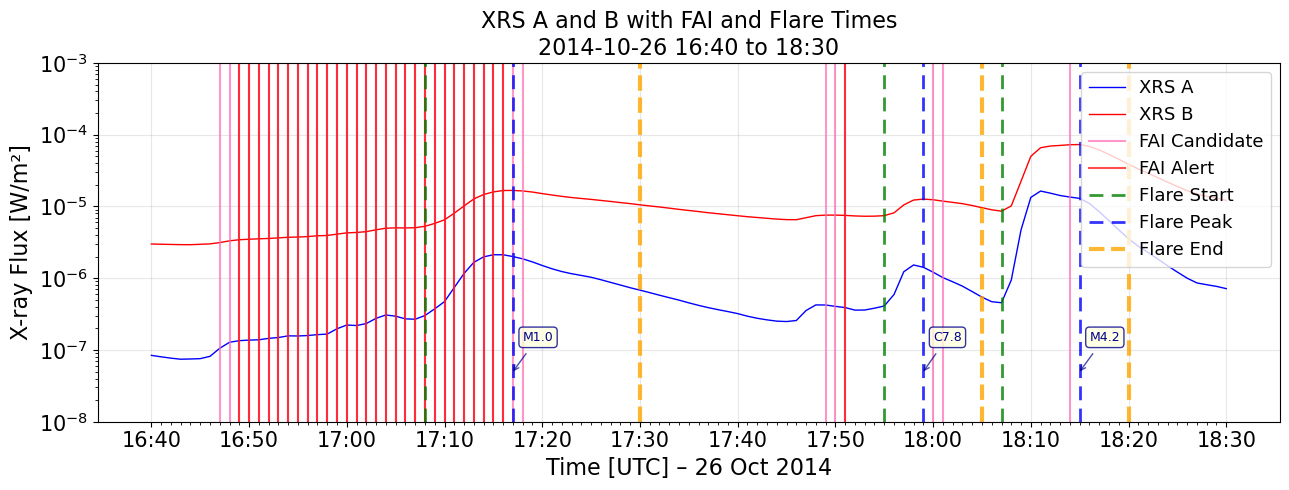

In [15]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_all=df_fai_all,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flares_valid,
    flare_start_time="2014-10-26 16:40:00",
    flare_end_time="2014-10-26 18:30:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-3)

In [16]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_all=df_fai_all,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flares_valid,
    flare_start_time="1989-06-06 16:00:00",
    flare_end_time="1989-06-06 19:00:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-3)

Buscando datos entre: 1989-06-06 16:00:00 y 1989-06-06 19:00:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 1989-06-06 16:00:00 a 1989-06-06 19:00:00


Buscando datos entre: 2001-11-04 15:00:00 y 2001-11-04 16:00:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 61
Datos en df_fai_interval: 24
Fulguraciones encontradas en el intervalo: 1


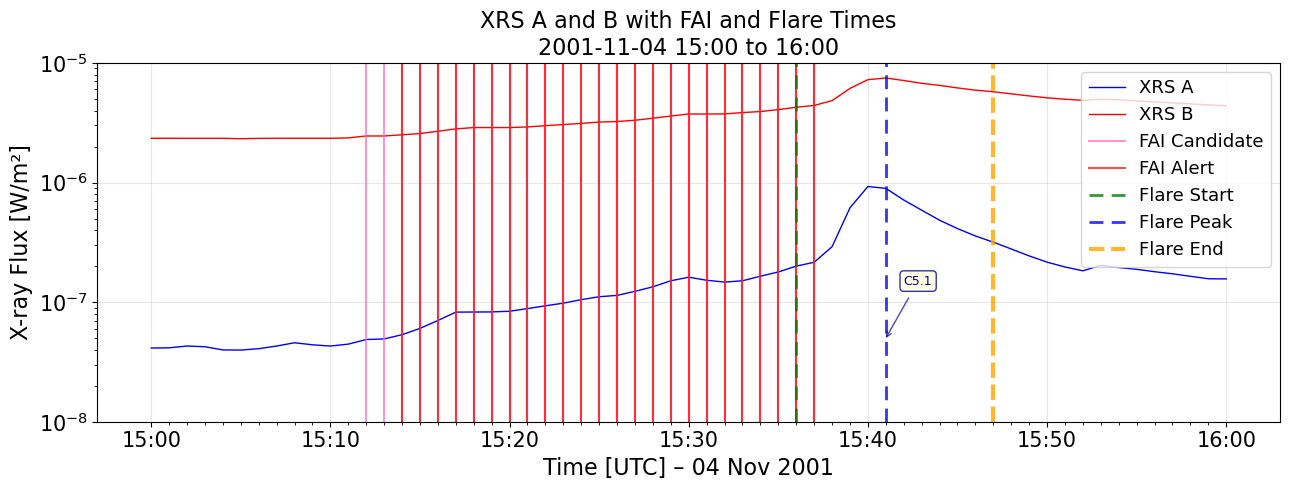

In [17]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_all=df_fai_all,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flares_valid,
    flare_start_time="2001-11-04 15:00:00",
    flare_end_time="2001-11-04 16:00:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-5)

In [18]:
plot_fai_and_flare_lines(
    df_combined=df_full,
    df_fai_all=df_fai_all,
    df_fai_selected=df_fai_selected,
    df_flare_data=df_flares_valid,
    flare_start_time="1992-02-07 11:40:00",
    flare_end_time="1992-02-07 14:40:00", 
    graphics_dir=graphics_dir,
    ymin=1e-8, ymax=1e-5)


Buscando datos entre: 1992-02-07 11:40:00 y 1992-02-07 14:40:00
Rango df_combined: 2000-06-06 00:00:00 a 2025-06-19 23:59:00
Rango df_fai_selected: 2000-06-06 00:17:00 a 2025-06-19 23:46:00
Rango df_flare_data PeakTime: 2000-06-06 00:43:00 a 2025-06-19 19:29:00
Datos en df_plot: 0
Datos en df_fai_interval: 0
¡ADVERTENCIA! No hay datos en df_combined para el rango 1992-02-07 11:40:00 a 1992-02-07 14:40:00


## Análisis correlaciones

Datos válidos para graficar: 1764


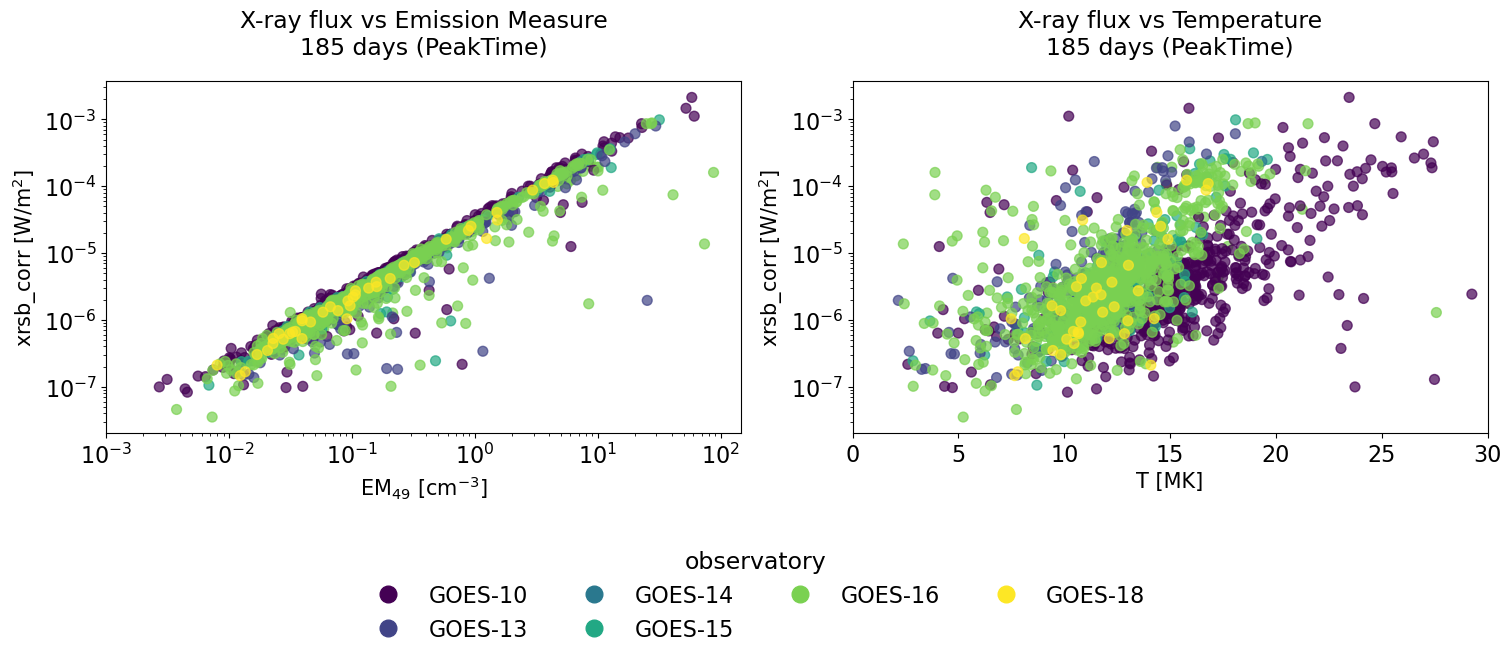

In [19]:

# Uso:
plot_xrs_vs_te_simple(days=n, 
                     df_full_valid=df_full_valid, 
                     df_flares_valid=df_flares_valid, 
                     color_by="observatory")

Datos válidos para graficar: 1764


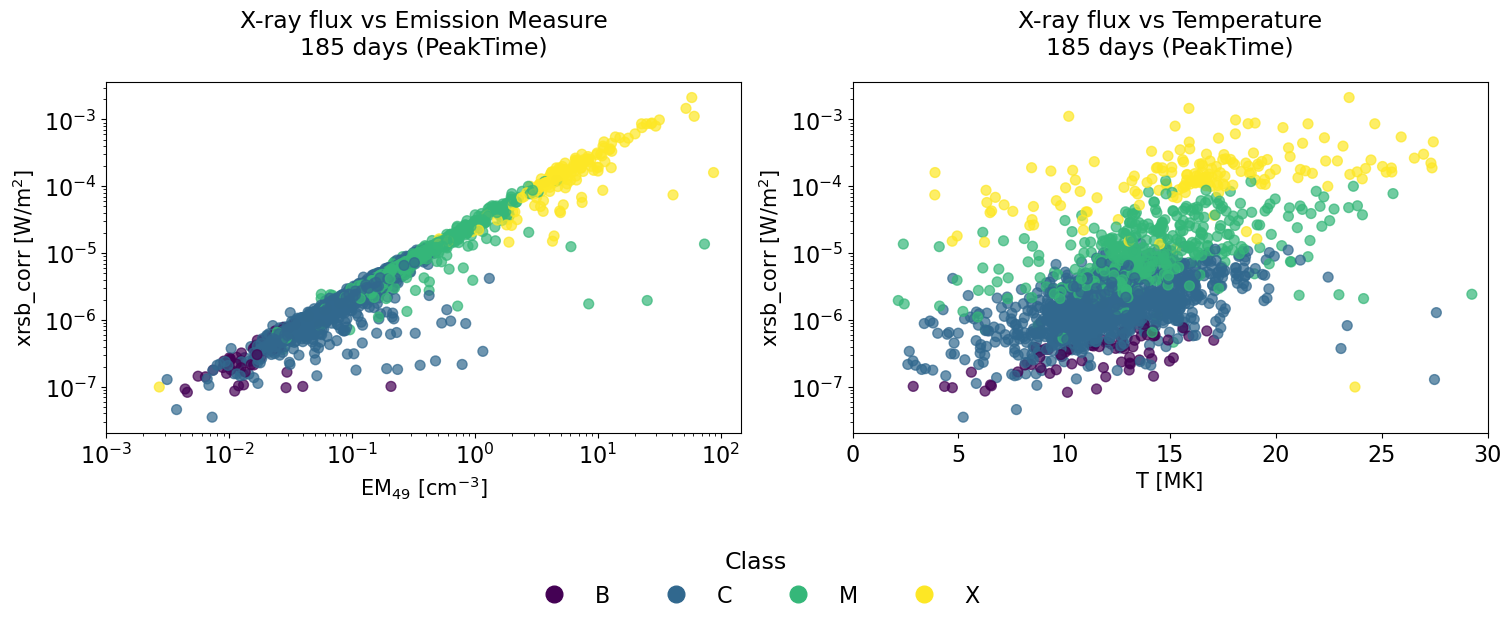

In [20]:
plot_xrs_vs_te_simple(days=n, 
                         df_full_valid = df_full_valid, 
                         df_flares_valid = df_flares_valid, 
                         time_column="PeakTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by="Class",
                         palette="viridis",  
                         class_to_color=None)

Datos válidos para graficar: 720


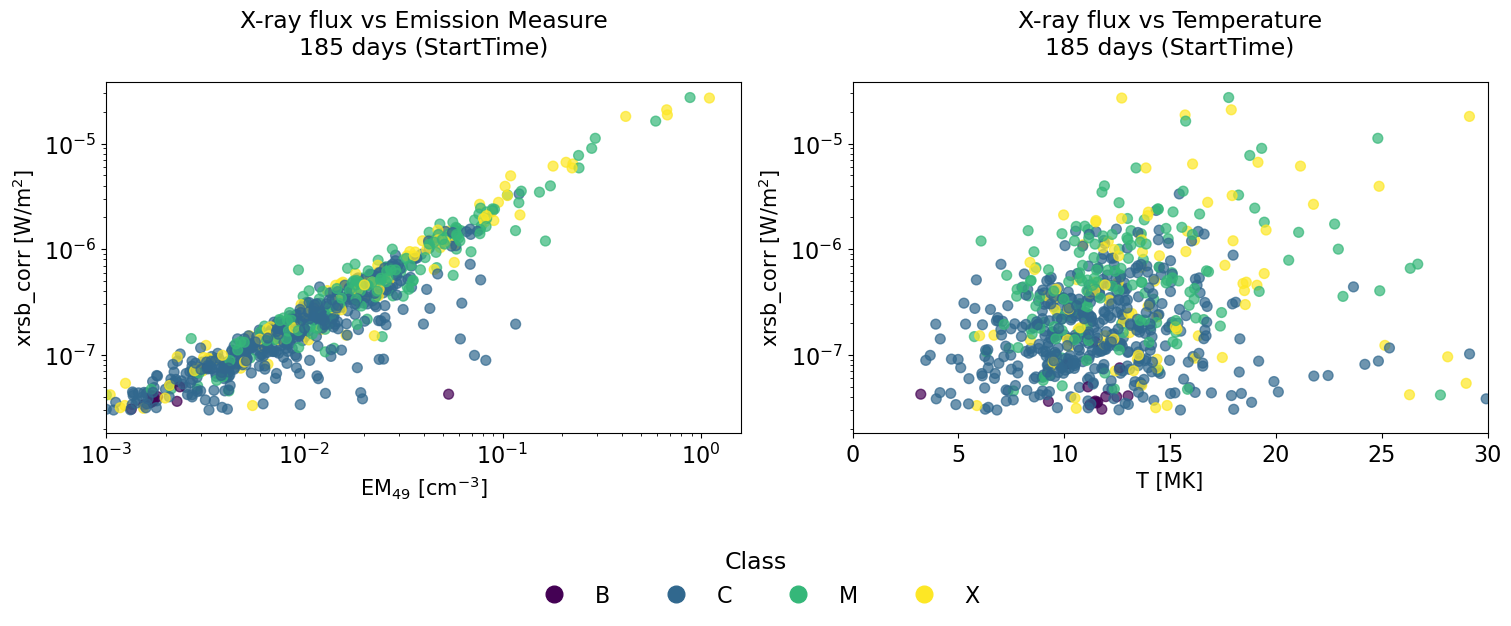

In [21]:
plot_xrs_vs_te_simple(days=n, 
                         df_full_valid = df_full_valid, 
                         df_flares_valid = df_flares_valid, 
                         time_column="StartTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by="Class",
                         palette="viridis",  
                         class_to_color=None)

Datos válidos para graficar: 123


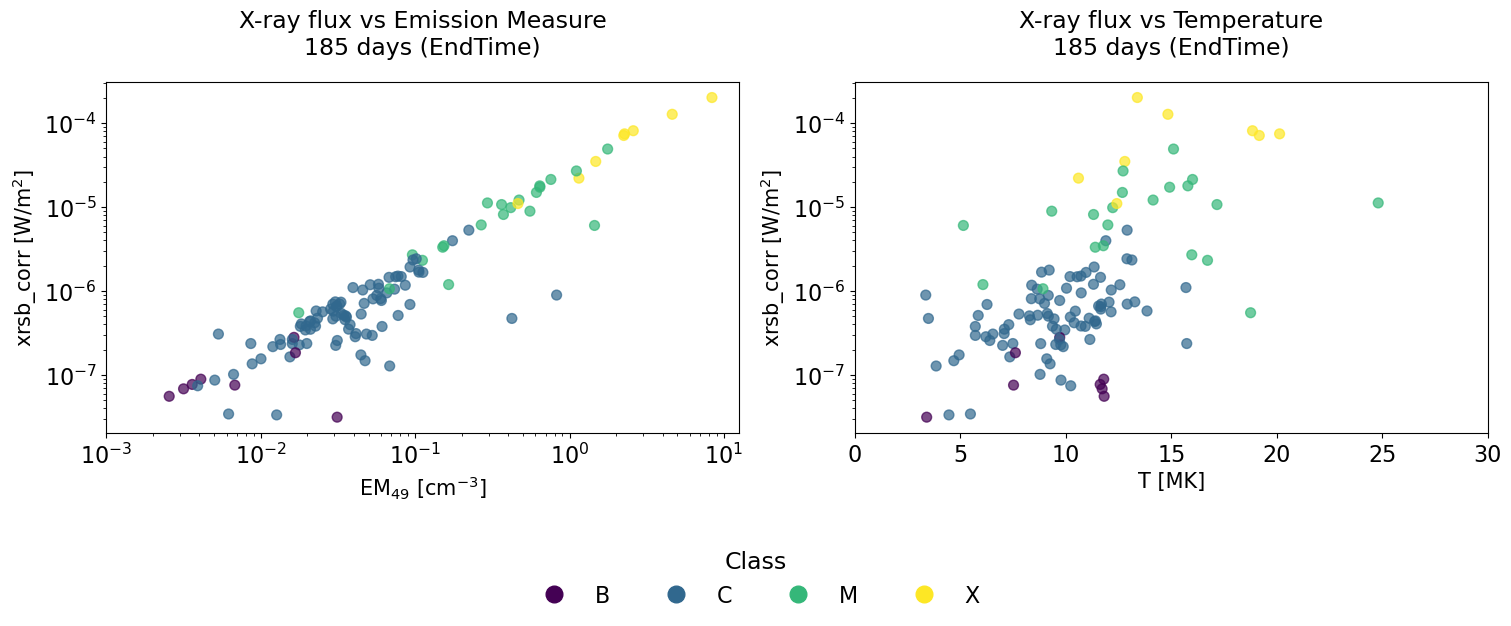

In [22]:
plot_xrs_vs_te_simple(days=n, 
                         df_full_valid = df_full_valid, 
                         df_flares_valid = df_flares_valid, 
                         time_column="EndTime",
                         XRS="xrsb_corr", T="T_cor", EM="EM_cor_norm",
                         color_by="Class",
                         palette="viridis",  
                         class_to_color=None)

In [23]:
df_full_valid.head()

,GOES_ID,date,observatory,xrsa,xrsb,xrsa_corr,xrsb_corr,T_cor,EM_cor,T_phot,EM_phot,EM_cor_norm,EM_phot_norm
0,GOES_0,2000-06-06 00:05:00,GOES-16,1.220925e-08,8.860234e-07,3.788372e-09,3.142395e-08,12.571802,1.839645e+46,11.630426,4.512600e+46,0.001840,0.004513
1,GOES_1,2000-06-06 00:06:00,GOES-16,1.346536e-08,8.977652e-07,5.258025e-09,4.601407e-08,12.297073,2.748919e+46,11.315239,6.866820e+46,0.002749,0.006867
2,GOES_2,2000-06-06 00:07:00,GOES-16,1.536368e-08,9.099479e-07,7.282076e-09,5.697751e-08,12.875831,3.267130e+46,11.983715,7.855587e+46,0.003267,0.007856
3,GOES_3,2000-06-06 00:08:00,GOES-16,1.425506e-08,9.134990e-07,4.896752e-09,5.101930e-08,11.426795,3.280485e+46,10.346220,8.692047e+46,0.003280,0.008692
4,GOES_4,2000-06-06 00:09:00,GOES-16,1.343720e-08,9.078860e-07,2.276667e-09,3.068232e-08,10.207486,2.251486e+46,9.086091,6.454625e+46,0.002251,0.006455


In [24]:
df_flares_valid.head()

,Flare_ID,StartTime,PeakTime,EndTime,Class,ClassLetter,ClassNumber,ClassGroup,Observatory,StartPeak,PeakEnd,StartEnd
0,Flare_20000606_0,2000-06-06 00:28:00,2000-06-06 00:43:00,2000-06-06 00:55:00,C4.6,C,4.6,C1-4.9,GOES,15.0,12.0,27.0
1,Flare_20000606_1,2000-06-06 01:30:00,2000-06-06 01:49:00,2000-06-06 02:01:00,C2.4,C,2.4,C1-4.9,GOES,19.0,12.0,31.0
2,Flare_20000606_2,2000-06-06 08:06:00,2000-06-06 08:16:00,2000-06-06 08:34:00,C2.8,C,2.8,C1-4.9,GOES,10.0,18.0,28.0
3,Flare_20000606_3,2000-06-06 08:47:00,2000-06-06 08:51:00,2000-06-06 08:54:00,C2.4,C,2.4,C1-4.9,GOES,4.0,3.0,7.0
4,Flare_20000606_4,2000-06-06 11:23:00,2000-06-06 11:27:00,2000-06-06 11:29:00,C1.8,C,1.8,C1-4.9,GOES,4.0,2.0,6.0


## Analysis FAI

### Flare with FAI before

In [25]:
def plot_fai_analysis_summary(df_anticipation_time, n_days, window_minutes,
                             fai_metric="FAIalerts_StartPeak",  # Puedes cambiar por otras columnas
                             group_subclasses=False,
                             color_mode="palette:viridis"):
    """
    Versión especializada para análisis FAI con diferentes métricas disponibles.
    
    Métricas FAI disponibles:
    - "FAIalerts_W": Alertas en ventana completa
    - "FAIalerts_WStart": Alertas desde ventana start
    - "FAIalerts_StartPeak": Alertas entre start y peak
    - "FAIalerts_PeakEnd": Alertas entre peak y end
    - "AnticipationStart": Tiempo de anticipación desde start
    - "AnticipationPeak": Tiempo de anticipación desde peak
    """
    
    df = df_anticipation_time.copy()
    
    # Verificar que la métrica existe
    if fai_metric not in df.columns:
        available_metrics = [col for col in df.columns if 'FAI' in col or 'Anticipation' in col]
        raise ValueError(f"Métrica '{fai_metric}' no encontrada. Disponibles: {available_metrics}")
    
    print(f"Usando métrica FAI: {fai_metric}")
    
    # Determinar si es booleano (conteo) o numérico (tiempo)
    if 'Anticipation' in fai_metric:
        # Es una métrica de tiempo - calcular % con anticipación > 0
        df['FAI_bool'] = df[fai_metric] > 0
        metric_type = "Tiempo de anticipación"
    else:
        # Es una métrica de conteo - calcular % con al menos 1 alerta
        df['FAI_bool'] = df[fai_metric] > 0
        metric_type = "Alertas FAI"
    
    # Agrupación de clases (igual que antes)
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],
    }
    
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}-" + (f"{high}" if high < 1000 else "+")
        return flare_class

    if group_subclasses:
        df["ClassGroup"] = df["Class"].apply(lambda x: assign_flare_group(str(x)))
    else:
        df["ClassGroup"] = df["Class"].astype(str)

    # Cálculos
    group_col = "ClassGroup"
    flare_summary = (df.groupby(group_col)['FAI_bool'].mean() * 100).reset_index()
    flare_summary.rename(columns={'FAI_bool': "FAI_percent"}, inplace=True)
    flare_counts = df.groupby(group_col)['FAI_bool'].count()

    classes = flare_summary[group_col].tolist()
    values = flare_summary["FAI_percent"].tolist()
    n_bars = len(classes)

    # Configuración de colores (igual que antes)
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato"}
        colors = [base_colors.get(str(c)[0], "gray") for c in classes]
    else:
        colors = "skyblue"

    # Plot
    chart_width = max(8, n_bars * 1.2)
    chart_height = 6

    fig, (ax, ax_leg) = plt.subplots(2, 1, figsize=(chart_width, chart_height), 
                                    gridspec_kw={'height_ratios': [3, 1]})

    # Barras principales
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)
    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=45, ha="right")

    # Etiquetas
    for bar, value in zip(bars, values):
        if value < 100:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f"{value:.1f}%", ha="center", va="bottom", fontsize=12)

    ax.set_ylim(0, 100)
    ax.set_ylabel("FAI Detection Rate (%)")
    ax.set_xlabel("Flare Class")
    ax.set_title(f"FAI Detection by Flare Class\n({fai_metric}, {n_days} days, {window_minutes} min window)")
    ax.axhline(y=50, color='red', linestyle='--', alpha=0.3)

    # Leyenda
    ax_leg.axis("off")
    legend_labels = [f"{cls} (n={flare_counts[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i]) for i in range(n_bars)]
    
    ncol = min(n_bars, 6)
    ax_leg.legend(handles=handles, loc="center", ncol=ncol, frameon=False,
                  title=f"Flare counts (Total: {len(df)})")

    plt.tight_layout()

    # Guardar
    output_name = f"FAI_Analysis_{fai_metric}_{n_days}d_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")

    # Estadísticas
    total = len(df)
    with_fai = df['FAI_bool'].sum()
    print(f"\n--- Resumen {fai_metric} ---")
    print(f"Total flares: {total}")
    print(f"Flares con FAI: {with_fai} ({with_fai/total*100:.1f}%)")
    print(f"Métrica: {metric_type}")


# También puedes probar con otras métricas:
# plot_fai_analysis_summary(..., fai_metric="AnticipationStart")
# plot_fai_analysis_summary(..., fai_metric="FAIalerts_W")

Usando métrica FAI: FAIalerts_StartPeak


/tmp/ipykernel_5879/1463160967.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


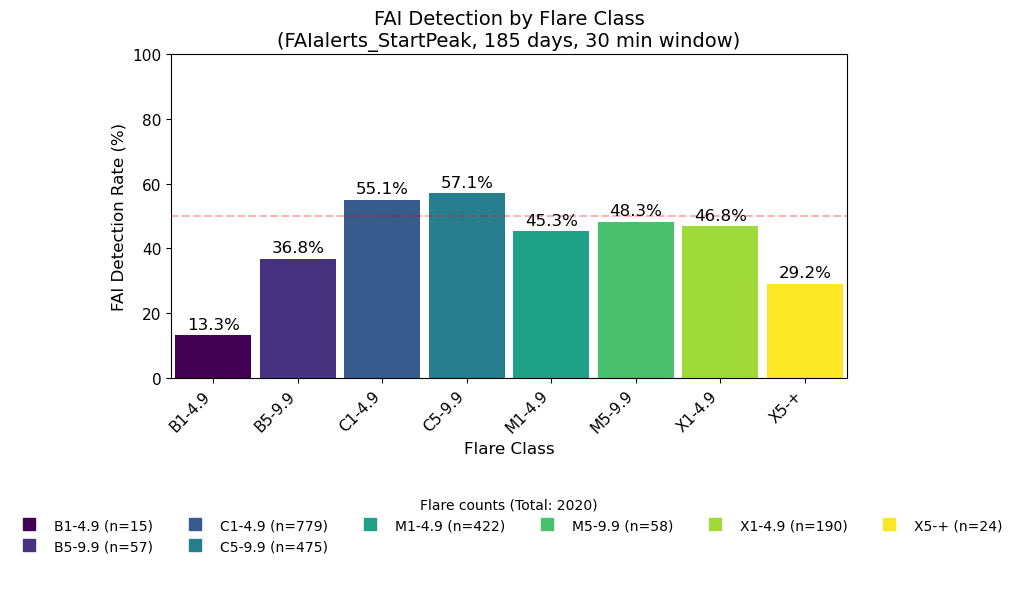

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/FAI_Analysis_FAIalerts_StartPeak_185d_Window30min.png

--- Resumen FAIalerts_StartPeak ---
Total flares: 2020
Flares con FAI: 1038 (51.4%)
Métrica: Alertas FAI


In [52]:
# Ejemplos de uso:
plot_fai_analysis_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes,
    fai_metric="FAIalerts_StartPeak",  # Alertas entre start y peak
    group_subclasses=True,
    color_mode="palette:viridis"
)


Usando métrica FAI: FAIalerts_WPeak


/tmp/ipykernel_5879/1463160967.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


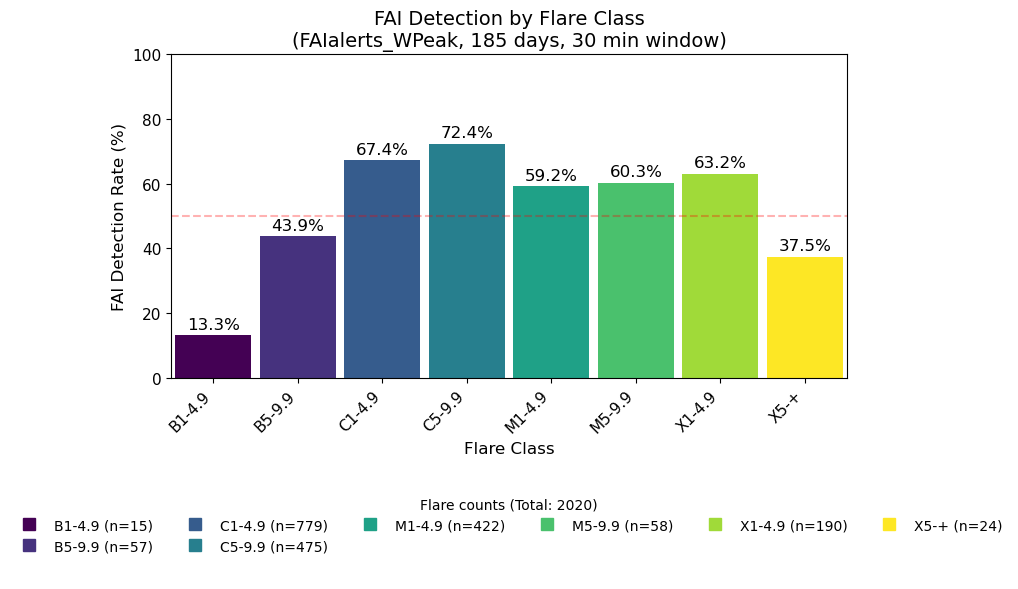

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/FAI_Analysis_FAIalerts_WPeak_185d_Window30min.png

--- Resumen FAIalerts_WPeak ---
Total flares: 2020
Flares con FAI: 1310 (64.9%)
Métrica: Alertas FAI


In [53]:
# Ejemplos de uso:
plot_fai_analysis_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes,
    fai_metric="FAIalerts_WPeak",  # Alertas entre start y peak
    group_subclasses=True,
    color_mode="palette:viridis"
)

Usando métrica FAI: FAIalerts_StartPeak


/tmp/ipykernel_5879/1463160967.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


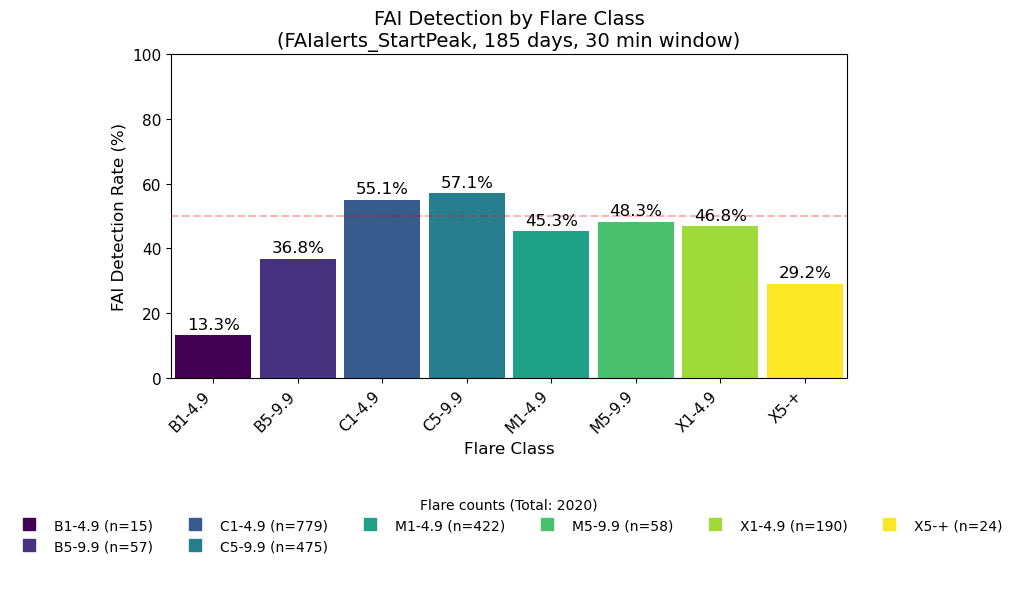

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/FAI_Analysis_FAIalerts_StartPeak_185d_Window30min.png

--- Resumen FAIalerts_StartPeak ---
Total flares: 2020
Flares con FAI: 1038 (51.4%)
Métrica: Alertas FAI


In [54]:
# Ejemplos de uso:
plot_fai_analysis_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes,
    fai_metric="FAIalerts_StartPeak",  # Alertas entre start y peak
    group_subclasses=True,
    color_mode="palette:viridis"
)

Usando métrica FAI: FAIalerts_PeakEnd


/tmp/ipykernel_5879/1463160967.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


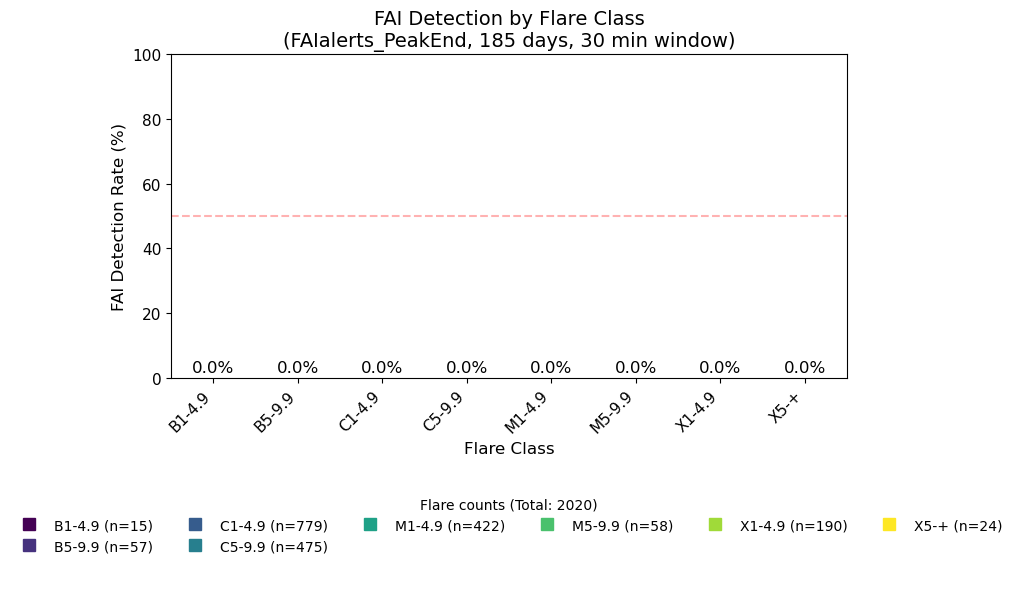

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/FAI_Analysis_FAIalerts_PeakEnd_185d_Window30min.png

--- Resumen FAIalerts_PeakEnd ---
Total flares: 2020
Flares con FAI: 0 (0.0%)
Métrica: Alertas FAI


In [55]:
# Ejemplos de uso:
plot_fai_analysis_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes,
    fai_metric="FAIalerts_PeakEnd",  # Alertas entre start y peak
    group_subclasses=True,
    color_mode="palette:viridis"
)

In [30]:
df_anticipation_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Flare_ID                    2020 non-null   object        
 1   StartTime                   2020 non-null   datetime64[ns]
 2   PeakTime                    2020 non-null   datetime64[ns]
 3   EndTime                     2020 non-null   datetime64[ns]
 4   Class                       2020 non-null   object        
 5   ClassLetter                 2020 non-null   object        
 6   ClassNumber                 2020 non-null   float64       
 7   ClassGroup                  2020 non-null   object        
 8   Observatory                 2020 non-null   object        
 9   StartPeak                   2020 non-null   float64       
 10  PeakEnd                     2020 non-null   float64       
 11  StartEnd                    2020 non-null   float64     

In [31]:
def plot_anticipation_time_summary(df_anticipation_time, n_days, window_minutes):
    """
    Gráfica especializada para tiempos de anticipación FAI.
    """
    df = df_anticipation_time.copy()
    
    # Columnas de tiempo de anticipación
    time_columns = [col for col in df.columns if 'Anticipation' in col or 'Time_since' in col]
    time_columns = [col for col in time_columns if df[col].dtype in ['float64', 'int64']]
    
    if not time_columns:
        print("No se encontraron columnas de tiempo de anticipación numéricas")
        return
    
    n_metrics = len(time_columns)
    fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
    
    if n_metrics == 1:
        axes = [axes]
    
    for i, time_col in enumerate(time_columns):
        ax = axes[i]
        
        # Filtrar valores válidos
        valid_times = df[time_col].dropna()
        
        if len(valid_times) == 0:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{time_col}\n(No data)")
            continue
        
        # Crear histograma
        ax.hist(valid_times, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
        
        ax.set_xlabel("Time (minutes)")
        ax.set_ylabel("Frequency")
        ax.set_title(f"{time_col}\n(n={len(valid_times)})")
        
        # Estadísticas en el gráfico
        stats_text = f"Mean: {valid_times.mean():.1f} min\nMedian: {valid_times.median():.1f} min\nMax: {valid_times.max():.1f} min"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                ha='right', va='top', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.suptitle(f"FAI Anticipation Time Distribution ({n_days} days, Window = {window_minutes} min)", 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Guardar
    output_name = f"{n_days}d_FAI_Anticipation_Time_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")



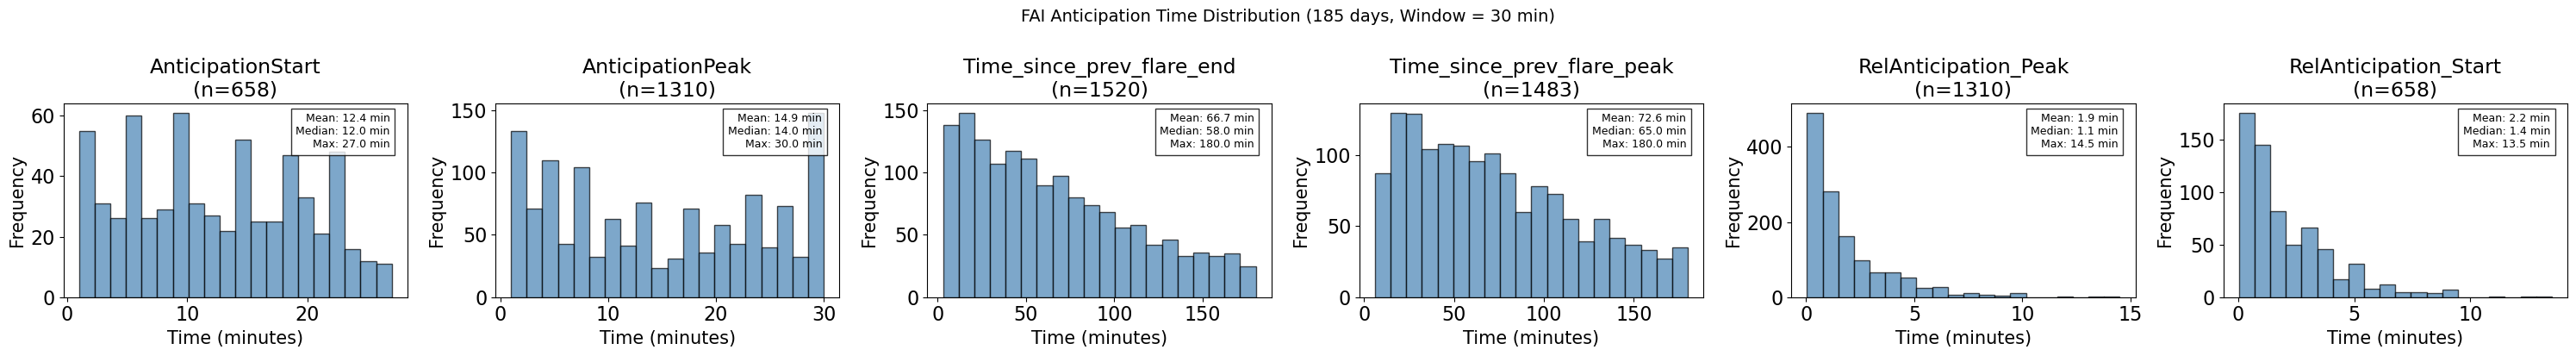

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/185d_FAI_Anticipation_Time_Window30min.png


In [32]:
# Uso para tiempos de anticipación:
plot_anticipation_time_summary(
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes
)

In [33]:
def plot_fai_association(df_anticipation_time, n_days, window_minutes, fai_column="FAIalerts_W"):
    """
    Genera una gráfica de barras mostrando cuántos flares tienen FAIs asociados.
    Con porcentaje dentro de la barra y número total encima.
    
    Parámetros:
    - df_anticipation_time: DataFrame con datos de anticipación FAI
    - n_days: número de días (para título)
    - window_minutes: ventana de tiempo (para título)
    - fai_column: nombre de la columna que indica si hay FAI asociado
    """
    df = df_anticipation_time.copy()
    window=fai_column
    # Verificar que la columna FAI existe
    if fai_column not in df.columns:
        available_columns = [col for col in df.columns if 'FAI' in col]
        raise ValueError(f"Columna '{fai_column}' no encontrada. Columnas disponibles con FAI: {available_columns}")
    
    print(f"Usando columna FAI: {fai_column}")
    
    # Convertir a booleano (si es numérica)
    if df[fai_column].dtype in ['int64', 'float64']:
        df['FAI_bool'] = df[fai_column] > 0
    else:
        df['FAI_bool'] = df[fai_column].astype(bool)

    # Contar cuántos flares tienen FAI y cuántos no
    counts = df['FAI_bool'].value_counts()
    total = counts.sum()
    
    # Reordenar para que True = With FAI aparezca primero
    counts = counts.reindex([True, False])

    # Calcular porcentajes
    percentages = (counts / total * 100).round(1)
    
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 14
    })

    # Crear la gráfica
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([0, 1], percentages, color=['skyblue', 'salmon'])
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['With FAI', 'Without FAI'])
    ax.set_ylabel("Percentage of Flares (%)")
    ax.set_title(f"Flares with Associated FAIs ({n_days} days, Window = {window_minutes} min, {window})",
                 pad=20)
    
    # Agregar porcentaje dentro de las barras
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', 
                    fontsize=14, color="black", fontweight='bold')
    
    # Agregar número total arriba de las barras
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 2,
                    f"{int(count)}",
                    ha='center', va='bottom', 
                    fontsize=12, color="black")
    
    # Leyenda con total de flares en esquina superior derecha
    ax.text(0.95, 0.95, f"Total Flares = {total}",
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura
    output_name = f"{n_days}d_Flares_with_FAIs_perc_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas adicionales
    flares_with_fai = counts.get(True, 0)
    flares_without_fai = counts.get(False, 0)
    
    print(f"\n--- Estadísticas FAI ---")
    print(f"Total flares analizados: {total}")
    print(f"Flares con FAI: {flares_with_fai} ({percentages.get(True, 0):.1f}%)")
    print(f"Flares sin FAI: {flares_without_fai} ({percentages.get(False, 0):.1f}%)")
    print(f"Columna FAI utilizada: {fai_column}")



Usando columna FAI: FAIalerts_W


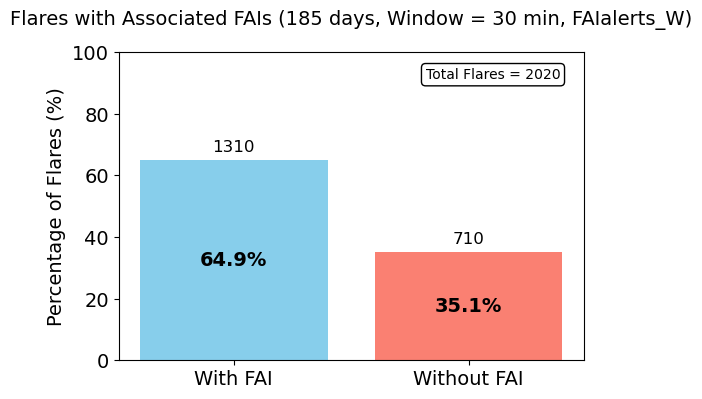

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/185d_Flares_with_FAIs_perc_Window30min.png

--- Estadísticas FAI ---
Total flares analizados: 2020
Flares con FAI: 1310 (64.9%)
Flares sin FAI: 710 (35.1%)
Columna FAI utilizada: FAIalerts_W


In [34]:
# Ahora puedes usar la función así:
plot_fai_association(
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes,
    fai_column="FAIalerts_W"  # Puedes cambiar por otras columnas FAI
)

In [35]:
def plot_comprehensive_fai_analysis(df_anticipation_time, n_days, window_minutes):
    """
    Análisis FAI comprehensivo con diferentes tipos de gráficas en cuadrícula 2xN.
    Incluye: asociación FAI, tiempos de anticipación, y distribución por clase.
    """
    df = df_anticipation_time.copy()
    
    # 1. Gráficas de asociación FAI (booleanas)
    fai_bool_columns = [col for col in df.columns if 'FAI' in col and 'Unnamed' not in col]
    
    # 2. Gráficas de tiempo de anticipación (numéricas)
    time_columns = [col for col in df.columns if 'Anticipation' in col or 'Time_since' in col]
    time_columns = [col for col in time_columns if df[col].dtype in ['float64', 'int64']]
    
    # Número total de gráficas
    n_bool = len(fai_bool_columns)
    n_time = len(time_columns)
    total_plots = n_bool + n_time
    
    if total_plots == 0:
        raise ValueError("No se encontraron columnas FAI para graficar")
    
    # Calcular cuadrícula
    n_cols = 2
    n_rows = (total_plots + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Manejar dimensiones
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    plot_count = 0
    
    # Gráficas booleanas primero
    for fai_column in fai_bool_columns:
        if plot_count >= total_plots:
            break
            
        i, j = plot_count // n_cols, plot_count % n_cols
        ax = axes[i, j]
        
        # Convertir a booleano
        if df[fai_column].dtype in ['int64', 'float64']:
            fai_bool = df[fai_column] > 0
        else:
            fai_bool = df[fai_column].astype(bool)
        
        counts = fai_bool.value_counts().reindex([True, False])
        total = len(df)
        percentages = (counts / total * 100).round(1)
        
        bars = ax.bar([0, 1], percentages, color=['lightgreen', 'lightcoral'])
        
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['With FAI', 'No FAI'], rotation=45)
        ax.set_ylabel("Percentage (%)")
        ax.set_title(f"{fai_column}\n(n={total})")
        ax.set_ylim(0, 100)
        
        # Porcentajes dentro de las barras
        for bar, pct in zip(bars, percentages):
            if pd.notna(pct):
                ax.text(bar.get_x() + bar.get_width()/2,
                        bar.get_height()/2,
                        f"{pct:.1f}%",
                        ha='center', va='center', 
                        fontsize=9, color="black", fontweight='bold')
        
        plot_count += 1
    
    # Gráficas de tiempo después
    for time_col in time_columns:
        if plot_count >= total_plots:
            break
            
        i, j = plot_count // n_cols, plot_count % n_cols
        ax = axes[i, j]
        
        # Filtrar valores válidos
        valid_times = df[time_col].dropna()
        
        if len(valid_times) > 0:
            # Histograma de tiempos
            ax.hist(valid_times, bins=15, alpha=0.7, color='steelblue', edgecolor='black')
            ax.set_xlabel("Time (minutes)")
            ax.set_ylabel("Frequency")
            ax.set_title(f"{time_col}\n(n={len(valid_times)})")
            
            # Estadísticas
            stats_text = f"Mean: {valid_times.mean():.1f} min\nMedian: {valid_times.median():.1f} min"
            ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
                    ha='right', va='top', fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{time_col}\n(No data)")
        
        plot_count += 1
    
    # Ocultar ejes sobrantes
    for i in range(plot_count, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].axis('off')
    
    plt.suptitle(f"Comprehensive FAI Analysis - {n_days} days (Window: {window_minutes} min)", 
                 fontsize=16, y=1.01)
    plt.tight_layout()
    
    # Guardar
    output_name = f"{n_days}d_FAI_Full_Analysis_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")



In [36]:
def plot_fai_association_compact_grid(df_anticipation_time, n_days, window_minutes):
    """
    Versión compacta con gráficas más pequeñas para muchas métricas.
    """
    df = df_anticipation_time.copy()
    
    # Identificar todas las columnas FAI disponibles
    fai_columns = [col for col in df.columns if 'FAI' in col and 'Unnamed' not in col]
    
    if not fai_columns:
        raise ValueError("No se encontraron columnas FAI en el dataframe")
    
    print(f"Columnas FAI encontradas: {fai_columns}")
    
    n_metrics = len(fai_columns)
    n_cols = 2
    n_rows = (n_metrics + 1) // 2
    
    # Tamaños más compactos para muchas métricas
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    
    # Manejar diferentes casos de dimensiones
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    plt.rcParams.update({
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8
    })
    
    metric_count = 0
    
    for i in range(n_rows):
        for j in range(n_cols):
            if metric_count < n_metrics:
                fai_column = fai_columns[metric_count]
                ax = axes[i, j]
                
                # Convertir a booleano
                if df[fai_column].dtype in ['int64', 'float64']:
                    fai_bool = df[fai_column] > 0
                else:
                    fai_bool = df[fai_column].astype(bool)
                
                counts = fai_bool.value_counts().reindex([True, False])
                total = len(df)
                percentages = (counts / total * 100).round(1)
                
                bars = ax.bar([0, 1], percentages, color=['lightgreen', 'lightcoral'], alpha=0.8)
                
                ax.set_xticks([0, 1])
                ax.set_xticklabels(['With\nFAI', 'No\nFAI'], fontsize=8)
                ax.set_ylabel("Percentage (%)", fontsize=9)
                ax.set_title(f"{fai_column}", fontsize=10, pad=5)
                ax.set_ylim(0, 100)
                ax.grid(True, alpha=0.3, axis='y')
                
                # Porcentajes dentro de las barras
                for bar, pct in zip(bars, percentages):
                    if pd.notna(pct):
                        ax.text(bar.get_x() + bar.get_width()/2,
                                bar.get_height()/2,
                                f"{pct:.1f}%",
                                ha='center', va='center', 
                                fontsize=8, color="black", fontweight='bold')
                
                # Conteos arriba de las barras
                for bar, count in zip(bars, counts):
                    if pd.notna(count):
                        ax.text(bar.get_x() + bar.get_width()/2,
                                bar.get_height() + 1,
                                f"n={int(count)}",
                                ha='center', va='bottom', 
                                fontsize=7, color="black")
                
                metric_count += 1
            else:
                # Ocultar ejes sobrantes
                axes[i, j].axis('off')
    
    plt.suptitle(f"FAI Association Analysis - {n_days} days (Window: {window_minutes} min)", 
                 fontsize=14, y=1.01)
    plt.tight_layout()
    
    # Guardar
    output_name = f"{n_days}d_FAI_Compact_Grid_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")



Columnas FAI encontradas: ['FAIalerts_W', 'FAIalerts_WStart', 'FAIalerts_WPeak', 'FAIalerts_StartPeak', 'FAIalerts_PeakEnd', 'FAIalerts_startEnd', 'Peak_to_lastFAI']


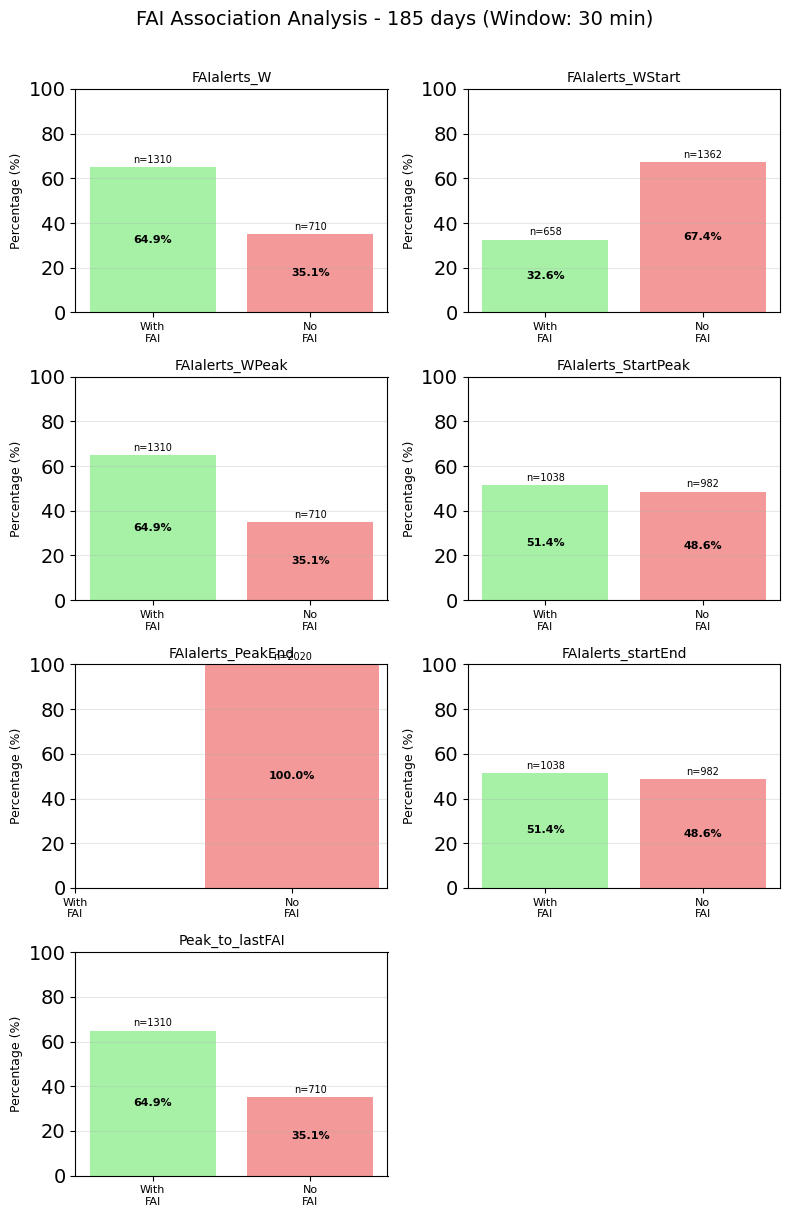

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/185d_FAI_Compact_Grid_Window30min.png


In [37]:

# Uso de la versión compacta:
plot_fai_association_compact_grid(
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes
)

## FAI associated to Flare

In [38]:
def plot_fai_association_summary(df_fai_assoc, n_days, window_minutes, column="Associated_Flare"):
    """
    Genera un gráfico de barras mostrando el porcentaje de FAIs
    que están asociados con flares (True) y no asociados (False).

    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare').
    n_days : int
        Número de días analizados (para título).
    window_minutes : int
        Ventana de tiempo en minutos usada para definir asociación.
    column : str, default="Associated_Flare"
        Nombre de la columna con valores True/False.
    """
    # Usar el dataframe directamente
    df_fai = df_fai_assoc.copy()

    # Verificar que la columna existe
    if column not in df_fai.columns:
        available_columns = df_fai.columns.tolist()
        raise ValueError(f"Columna '{column}' no encontrada. Columnas disponibles: {available_columns}")

    # Contar True (asociados) vs False (no asociados)
    counts = df_fai[column].value_counts()
    total = counts.sum()

    # Reordenar para que True = Asociados aparezca primero
    counts = counts.reindex([True, False])

    # Calcular porcentajes
    percentages = (counts / total * 100).round(1)

    # Configuración del plot
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    })

    # Crear figura
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar([0, 1], percentages, color=['lightgreen', 'lightcoral'], alpha=0.8)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Associated', 'Not Associated'])
    ax.set_ylabel("Percentage of FAIs (%)")
    ax.set_title(f"FAI Alerts Associated with Flares\n({n_days} days, Window = {window_minutes} min)",
                 pad=20)

    # Añadir porcentajes dentro de las barras
    for bar, pct in zip(bars, percentages):
        if pd.notna(pct):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height()/2,
                    f"{pct:.1f}%",
                    ha='center', va='center', 
                    fontsize=14, color="black", fontweight='bold')

    # Añadir conteos absolutos arriba de las barras
    for bar, count in zip(bars, counts):
        if pd.notna(count):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 1,
                    f"n={int(count)}",
                    ha='center', va='bottom', 
                    fontsize=12, color="black")

    # Recuadro con total de alertas FAI dentro del gráfico
    ax.text(0.95, 0.95, f"Total FAI Alerts = {total}",
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=11,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    ax.set_ylim(0, 100)  # escala fija para porcentaje

    # Guardar figura
    output_name = f"{n_days}d_FAI_associated_Flares_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas adicionales
    associated_count = counts.get(True, 0)
    not_associated_count = counts.get(False, 0)
    
    print(f"\n--- Estadísticas de Asociación FAI-Flare ---")
    print(f"Total alertas FAI analizadas: {total}")
    print(f"FAIs asociados a flares: {associated_count} ({percentages.get(True, 0):.1f}%)")
    print(f"FAIs no asociados: {not_associated_count} ({percentages.get(False, 0):.1f}%)")
    print(f"Ventana de asociación: {window_minutes} minutos")



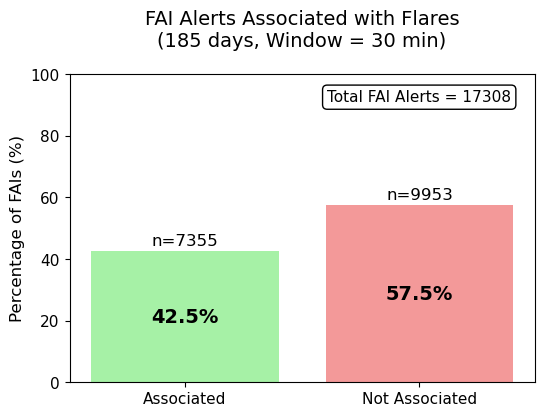

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/185d_FAI_associated_Flares_Window30min.png

--- Estadísticas de Asociación FAI-Flare ---
Total alertas FAI analizadas: 17308
FAIs asociados a flares: 7355 (42.5%)
FAIs no asociados: 9953 (57.5%)
Ventana de asociación: 30 minutos


In [39]:
# Ahora puedes usar la función así:
plot_fai_association_summary(
    df_fai_assoc=df_fai_assoc,
    n_days=n,
    window_minutes=window_minutes,
    column="Associated_Flare"
)

In [40]:
def plot_fai_distribution(df_fai_assoc, n_days, window_minutes,
                         class_col="F_Class",
                         assoc_col="Associated_Flare",
                         group_subclasses=False,
                         color_mode="palette:viridis"):
    """
    Plots the distribution of FAIs as percentages:
    - Fraction of FAIs associated with each flare class (or subrange if group_subclasses=True)
    - Fraction not associated with any flare ("No flare")
    
    Parameters:
    - df_fai_assoc: DataFrame with at least columns `class_col` and `assoc_col`
    - n_days: number of days analyzed (for title)
    - window_minutes: window in minutes (used for title)
    - group_subclasses: if True, subdivide flare classes into ranges (e.g., C1-4, C5-9)
    - color_mode: "palette:<name>", "single:<color>", or "by_class"
    """

    # Default group ranges para subclases
    group_ranges = {
        "A": [(1, 4.9), (5, 9.9)],
        "B": [(1, 4.9), (5, 9.9)],
        "C": [(1, 4.9), (5, 9.9)],
        "M": [(1, 4.9), (5, 9.9)],
        "X": [(1, 4.9), (5, 1000)],
    }

    df = df_fai_assoc.copy()

    # Verificar que las columnas necesarias existen
    if class_col not in df.columns or assoc_col not in df.columns:
        available_cols = df.columns.tolist()
        raise ValueError(f"DataFrame must contain '{class_col}' and '{assoc_col}'. Available columns: {available_cols}")

    print(f"Usando columnas: {class_col} para clases y {assoc_col} para asociación")
    print(f"Total FAIs en análisis: {len(df)}")

    # Función para agrupar subclases
    def assign_flare_group(flare_class):
        if not isinstance(flare_class, str) or len(flare_class) < 2:
            return flare_class
        letter = flare_class[0]
        try:
            number = float(flare_class[1:])
        except Exception:
            return flare_class
        for low, high in group_ranges.get(letter, []):
            if low <= number <= high:
                return f"{letter}{low}+" if (letter == "X" and high >= 1000) else f"{letter}{low}-{high}"
        return flare_class

    # --- Asignar grupos según parámetro ---
    if group_subclasses:
        df["ClassGroup"] = df[class_col].apply(lambda x: assign_flare_group(str(x)) if pd.notna(x) else x)
    else:
        # Extrae solo la letra principal (A, B, C, M, X)
        df["ClassGroup"] = df[class_col].astype(str).str[0]

    # Etiquetar FAIs no asociados
    df["AssocGroup"] = df.apply(
        lambda row: row["ClassGroup"] if row[assoc_col] else "No flare", axis=1
    )

    # Contar distribución
    counts = df["AssocGroup"].value_counts()

    # Ordenar clases: primero A, B, C, M, X o sus subrangos, luego "No flare"
    if group_subclasses:
        flare_classes = sorted([c for c in counts.index if c != "No flare"])
    else:
        flare_classes_order = ["A", "B", "C", "M", "X"]
        flare_classes = [cls for cls in flare_classes_order if cls in counts.index]

    if "No flare" in counts.index:
        flare_classes.append("No flare")

    counts_ordered = counts[flare_classes]
    percentages = (counts_ordered / counts_ordered.sum()) * 100

    classes = percentages.index.tolist()
    values = percentages.tolist()
    n_bars = len(classes)

    print(f"Distribución encontrada: {dict(zip(classes, counts_ordered))}")

    # Colores
    if color_mode.startswith("palette:"):
        cmap_name = color_mode.split(":", 1)[1]
        cmap = plt.cm.get_cmap(cmap_name, n_bars)
        colors = [cmap(i) for i in range(n_bars)]
    elif color_mode.startswith("single:"):
        single = color_mode.split(":", 1)[1]
        colors = [single] * n_bars
    elif color_mode == "by_class":
        base_colors = {"A": "skyblue", "B": "mediumseagreen",
                       "C": "gold", "M": "darkorange", "X": "tomato",
                       "No flare": "lightgray"}
        colors = [base_colors.get(str(c)[0], base_colors.get(c, "gray")) for c in classes]
    else:
        colors = "skyblue"

    # --- Layout con leyenda abajo ---
    chart_width = max(8, n_bars * 1.3)
    chart_height = 6.7

    fontsize = 10
    item_width = 0.25 * fontsize
    usable_width = chart_width * 0.9
    max_cols = int(usable_width / item_width)
    ncol = min(n_bars, max_cols)
    n_rows = int(np.ceil(n_bars / ncol))
    legend_height_ratio = max(0.55, 0.55 * n_rows)

    # --- Subplots ---
    plt.rcParams.update({
        "axes.titlesize": 17,
        "axes.labelsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 15,
        "legend.fontsize": 14
    })

    fig = plt.figure(figsize=(chart_width, chart_height))
    gs = fig.add_gridspec(2, 1, height_ratios=[6, legend_height_ratio], 
                          hspace=1.0) # espacio entre gráfico y leyenda
    
    # --- Gráfico de barras ---
    ax = fig.add_subplot(gs[0])
    bars = ax.bar(range(n_bars), values, color=colors, width=0.9)

    ax.set_xlim(-0.5, n_bars - 0.5)
    ax.set_ylim(0, max(values) * 1.1)

    ax.set_xticks(range(n_bars))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_ylabel("FAIs (% of total)")
    ax.set_xlabel("Flare Class (or No flare)")
    ax.set_title(f"Distribution of FAIs: Associated vs Not Associated\n({n_days} days, Window = {window_minutes} min)",
                 pad=20) # espacio entre título y gráfico

    # Etiquetas encima de las barras
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f"{value:.1f}%", ha="center", va="bottom", fontsize=14, fontweight='bold')

    # --- Leyenda abajo ---
    ax_leg = fig.add_subplot(gs[1])
    ax_leg.axis("off")

    legend_labels = [f"{cls} (n={counts_ordered[cls]})" for cls in classes]
    handles = [plt.Line2D([], [], marker="s", markersize=8, linestyle="",
                          color=colors[i], label=legend_labels[i])
               for i in range(n_bars)]

    ax_leg.legend(handles=handles,
                  loc="center",
                  ncol=ncol,
                  frameon=False,
                  title_fontsize=16, # tamaño titulo leyenda
                  title="Number of FAIs per group:")

    output_name = f"{n_days}d_Distribution_FAIs_All_Window{window_minutes}min_SubClass{group_subclasses}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas adicionales
    total_fais = len(df)
    associated_fais = df[assoc_col].sum()
    not_associated_fais = total_fais - associated_fais
    
    print(f"\n--- Estadísticas de Distribución FAI ---")
    print(f"Total FAIs: {total_fais}")
    print(f"FAIs asociados a flares: {associated_fais} ({associated_fais/total_fais*100:.1f}%)")
    print(f"FAIs no asociados: {not_associated_fais} ({not_associated_fais/total_fais*100:.1f}%)")
    
    if associated_fais > 0:
        print(f"\nDistribución de FAIs asociados por clase:")
        associated_by_class = df[df[assoc_col]]['ClassGroup'].value_counts()
        for cls, count in associated_by_class.items():
            percentage = (count / associated_fais) * 100
            print(f"  {cls}: {count} FAIs ({percentage:.1f}%)")



Usando columnas: F_Class para clases y Associated_Flare para asociación
Total FAIs en análisis: 17308
Distribución encontrada: {'B1-4.9': 3, 'B5-9.9': 58, 'C1-4.9': 2654, 'C5-9.9': 2070, 'M1-4.9': 1636, 'M5-9.9': 212, 'X1-4.9': 672, 'X5+': 50, 'No flare': 9953}


/tmp/ipykernel_5879/543647728.py:89: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, n_bars)


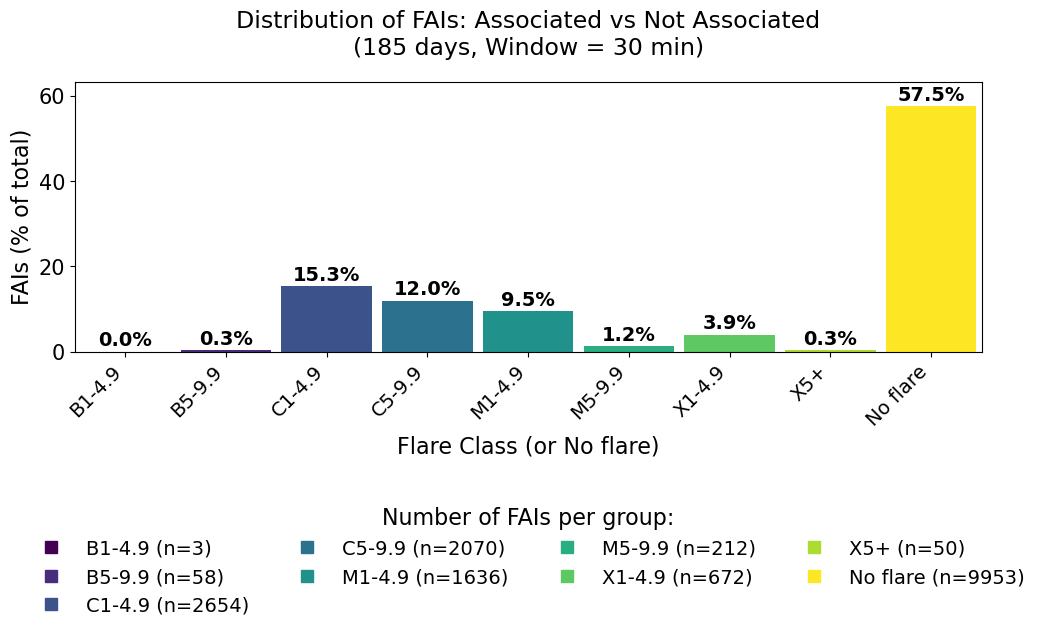

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/185d_Distribution_FAIs_All_Window30min_SubClassTrue.png

--- Estadísticas de Distribución FAI ---
Total FAIs: 17308
FAIs asociados a flares: 7355 (42.5%)
FAIs no asociados: 9953 (57.5%)

Distribución de FAIs asociados por clase:
  C1-4.9: 2654 FAIs (36.1%)
  C5-9.9: 2070 FAIs (28.1%)
  M1-4.9: 1636 FAIs (22.2%)
  X1-4.9: 672 FAIs (9.1%)
  M5-9.9: 212 FAIs (2.9%)
  B5-9.9: 58 FAIs (0.8%)
  X5+: 50 FAIs (0.7%)
  B1-4.9: 3 FAIs (0.0%)


In [41]:
# Ahora puedes usar la función así:
plot_fai_distribution(
    df_fai_assoc=df_fai_assoc,
    n_days=n,
    window_minutes=window_minutes,
    class_col="F_Class",
    assoc_col="Associated_Flare",
    group_subclasses=True,
    color_mode="palette:viridis"
)

In [42]:
def plot_anticipation_vs_te_dataframes(days,
                                      max_gap_fai,
                                      df_full_valid,
                                      df_flares_valid,
                                      df_anticipation_time,
                                      time_column="PeakTime",
                                      T="T_cor", 
                                      EM="EM_cor_norm",
                                      color_by=None,        # "Class" o "Date" u "Observatory"
                                      palette="viridis",
                                      class_to_color=None  # dict de colores fijos
                                      ):
    """
    Grafica:
      - T vs tiempo de anticipación
      - EM vs tiempo de anticipación
    usando los dataframes directamente.

    Parameters:
    - days: número de días analizados
    - max_gap_fai: ventana máxima de tiempo para FAI
    - df_full_valid: DataFrame con datos GOES completos
    - df_flares_valid: DataFrame con datos de fulguraciones
    - df_anticipation_time: DataFrame con tiempos de anticipación
    - time_column: columna de tiempo a usar ('PeakTime', 'StartTime', etc.)
    - T: columna de temperatura a usar
    - EM: columna de medida de emisión a usar
    - color_by: "Class", "Date", "Observatory" o None
    - palette: paleta de colores
    - class_to_color: diccionario de colores fijos
    """

    # Crear copias para no modificar los originales
    df_full = df_full_valid.copy()
    df_flares = df_flares_valid.copy()
    df_anticipation = df_anticipation_time.copy()

    # Convertir columnas de fecha a datetime si no lo están
    df_full['date'] = pd.to_datetime(df_full['date'])
    df_flares[time_column] = pd.to_datetime(df_flares[time_column])
    df_anticipation[time_column] = pd.to_datetime(df_anticipation[time_column])

    # Identificar la columna de anticipación (puede tener diferentes nombres)
    anticipation_col = None
    for col in ['AnticipationStart', 'AnticipationPeak', 'Anticipation (min)']:
        if col in df_anticipation.columns:
            anticipation_col = col
            break
    
    if anticipation_col is None:
        # Buscar cualquier columna que contenga "Anticipation"
        anticipation_cols = [col for col in df_anticipation.columns if 'Anticipation' in col]
        if anticipation_cols:
            anticipation_col = anticipation_cols[0]
        else:
            raise ValueError("No se encontró columna de anticipación en df_anticipation_time")

    print(f"Usando columna de anticipación: {anticipation_col}")

    anticipation_vals, t_vals, em_vals, flare_labels = [], [], [], []

    # Recorremos cada flare
    for _, flare in df_flares.iterrows():
        flare_time = flare[time_column]

        # Buscar anticipación en el dataframe correspondiente
        mask = df_anticipation[time_column] == flare_time
        row_ant = df_anticipation[mask]
        
        if row_ant.empty:
            continue

        delta_minutes = row_ant[anticipation_col].values[0]

        # Buscar datos físicos en df_full_valid (búsqueda por tiempo más cercano)
        time_diff = np.abs(df_full['date'] - flare_time)
        if len(time_diff) > 0:
            closest_idx = time_diff.argmin()
            flare_row = df_full.iloc[closest_idx]
            
            # Verificar que tenemos los datos necesarios
            if (pd.notna(flare_row[T]) and pd.notna(flare_row[EM]) and 
                pd.notna(delta_minutes) and delta_minutes > 0):
                
                anticipation_vals.append(delta_minutes)
                t_vals.append(flare_row[T])
                em_vals.append(flare_row[EM])

                if color_by == "Class":
                    flare_labels.append(str(flare["Class"])[0])   # letra de clase
                elif color_by == "Date":
                    flare_labels.append(flare_time.date())
                elif color_by == "Observatory":
                    # Usar observatorio del flare o del dato GOES
                    obs = flare.get("Observatory", flare_row.get("observatory", "Unknown"))
                    flare_labels.append(obs)
                else:
                    flare_labels.append("")

    # Verificar que tenemos datos
    if len(anticipation_vals) == 0:
        print("No se encontraron datos válidos para graficar")
        return

    print(f"Datos procesados: {len(anticipation_vals)} flares con anticipación")

    # --- Colores ---
    if color_by:
        labels = sorted(set(flare_labels))
        if class_to_color is None:
            cmap = plt.get_cmap(palette, len(labels))
            class_to_color = {lab: cmap(i) for i, lab in enumerate(labels)}
        colors = [class_to_color[lab] for lab in flare_labels]
    else:
        labels = []
        colors = "blue"

    # --- Subplots ---
    plt.rcParams.update({
        "axes.titlesize": 15,
        "axes.labelsize": 16,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        "legend.fontsize": 10 
    })
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # T vs Anticipación
    scatter1 = axes[0].scatter(t_vals, anticipation_vals, c=colors, alpha=0.7, s=50)
    axes[0].set_xlabel(f"{T} [MK]")
    axes[0].set_xlim(0, 30)   # T en el rango de 0 a 30 MK
    axes[0].set_ylabel("Anticipation Time [min]")
    axes[0].set_title(f"Temperature vs Anticipation\n({days} days, Window={max_gap_fai} min)")
    axes[0].set_yscale("log")   # Escala log en Y

    # EM vs Anticipación
    scatter2 = axes[1].scatter(em_vals, anticipation_vals, c=colors, alpha=0.7, s=50)
    axes[1].set_xlabel(rf"{EM} [cm$^{{-3}}$]")
    axes[1].set_ylabel("Anticipation Time [min]")
    axes[1].set_title(f"Emission Measure vs Anticipation\n({days} days, Window={max_gap_fai} min)")
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")   # Y en log

    # --- Formato personalizado para logs ---
    def log_format(x, pos):
        # Si es un entero, mostrarlo sin decimales
        if x >= 1:
            return f"{int(x)}"
        else:
            # Para los menores de 1, mostrar en notación decimal normal
            return f"{x:.3f}".rstrip("0").rstrip(".")

    formatter = FuncFormatter(log_format)

    for ax in axes:
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        
        # Añadir grid para mejor lectura
        ax.grid(True, alpha=0.3)

    # --- Leyenda ---
    if color_by and labels:
        handles = [plt.Line2D([], [], marker="o", color=class_to_color[lab], linestyle="", 
                              label=str(lab), markersize=8) for lab in labels]
        fig.legend(handles=handles, title=color_by,
                   loc="upper center",
                   bbox_to_anchor=(0.5, -0.05),
                   ncol=min(len(labels), 8),
                   frameon=False,
                   fontsize=10)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Guardar
    output_name = f"{days}d_AnticipationTime_vs_T_EM_Window{max_gap_fai}min_Color{color_by}.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas
    print(f"\n--- Estadísticas de Anticipación ---")
    print(f"Tiempo de anticipación promedio: {np.mean(anticipation_vals):.1f} min")
    print(f"Tiempo de anticipación mediano: {np.median(anticipation_vals):.1f} min")
    print(f"Tiempo de anticipación máximo: {np.max(anticipation_vals):.1f} min")
    print(f"Tiempo de anticipación mínimo: {np.min(anticipation_vals):.1f} min")
    print(f"Temperatura promedio: {np.mean(t_vals):.1f} MK")
    print(f"EM promedio: {np.mean(em_vals):.3f}")



Usando columna de anticipación: AnticipationStart
Datos procesados: 658 flares con anticipación


/tmp/ipykernel_5879/2149351901.py:175: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


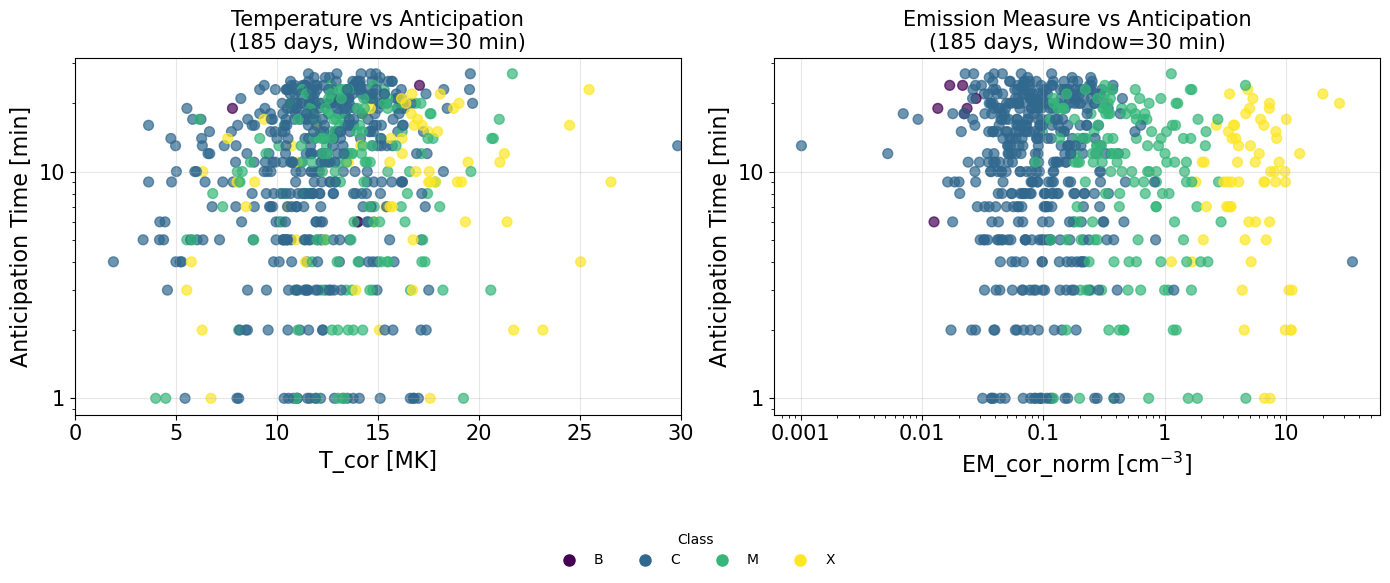

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/185d_AnticipationTime_vs_T_EM_Window30min_ColorClass.png

--- Estadísticas de Anticipación ---
Tiempo de anticipación promedio: 12.4 min
Tiempo de anticipación mediano: 12.0 min
Tiempo de anticipación máximo: 27.0 min
Tiempo de anticipación mínimo: 1.0 min
Temperatura promedio: 12.7 MK
EM promedio: 0.914


In [43]:
# Ahora puedes usar la función así:
plot_anticipation_vs_te_dataframes(
    days=n,
    max_gap_fai=window_minutes,
    df_full_valid=df_full_valid,
    df_flares_valid=df_flares_valid,
    df_anticipation_time=df_anticipation_time,
    time_column="PeakTime",
    T="T_cor", 
    EM="EM_cor_norm",
    color_by="Class",
    palette="viridis"
)

# FAI a pico del flare

In [44]:
def plot_fai_to_peak_times(df_fai_assoc, n_days, window_minutes, bins=20):
    """
    Muestra la distribución de tiempos desde FAI hasta el pico del flare.
    """
    # Filtrar FAIs asociados con tiempo válido
    df_associated = df_fai_assoc[
        (df_fai_assoc['Associated_Flare'] == True) & 
        (df_fai_assoc['Time_to_flare'].notna()) &
        (df_fai_assoc['Time_to_flare'] > 0)
    ].copy()
    
    if len(df_associated) == 0:
        print("No hay FAIs asociados con tiempos válidos")
        return
    
    times = df_associated['Time_to_flare'].values
    
    # Configuración
    plt.rcParams.update({
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histograma
    n, bins, patches = ax1.hist(times, bins=bins, alpha=0.7, color='steelblue', 
                               edgecolor='black', density=False)
    ax1.set_xlabel('Time from FAI to Peak (minutes)')
    ax1.set_ylabel('Number of FAIs')
    ax1.set_title(f'Distribution of FAI-to-Peak Times\n({n_days} days, Window: {window_minutes} min)')
    ax1.grid(True, alpha=0.3)
    
    # Añadir línea de media y mediana
    mean_time = np.mean(times)
    median_time = np.median(times)
    ax1.axvline(mean_time, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_time:.1f} min')
    ax1.axvline(median_time, color='orange', linestyle='--', linewidth=2,
                label=f'Median: {median_time:.1f} min')
    ax1.legend()
    
    # Boxplot
    ax2.boxplot(times, vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7),
               medianprops=dict(color='red', linewidth=2),
               whiskerprops=dict(color='black', linewidth=1),
               capprops=dict(color='black', linewidth=1))
    ax2.set_ylabel('Time from FAI to Peak (minutes)')
    ax2.set_title('Boxplot of FAI-to-Peak Times')
    ax2.set_xticks([1])
    ax2.set_xticklabels(['FAI Times'])
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Añadir puntos individuales para ver distribución
    y_jitter = np.random.normal(1, 0.04, size=len(times))
    ax2.scatter(y_jitter, times, alpha=0.4, color='blue', s=30)
    
    plt.tight_layout()
    
    # Guardar
    output_name = f"{n_days}d_FAI_to_Peak_Times_Distribution_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas
    print(f"\n=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===")
    print(f"Total FAIs asociados: {len(df_associated)}")
    print(f"Tiempo mínimo: {np.min(times):.1f} minutos")
    print(f"Tiempo máximo: {np.max(times):.1f} minutos")
    print(f"Tiempo promedio: {mean_time:.1f} minutos")
    print(f"Tiempo mediano: {median_time:.1f} minutos")
    print(f"Desviación estándar: {np.std(times):.1f} minutos")
    print(f"Percentil 25: {np.percentile(times, 25):.1f} minutos")
    print(f"Percentil 75: {np.percentile(times, 75):.1f} minutos")



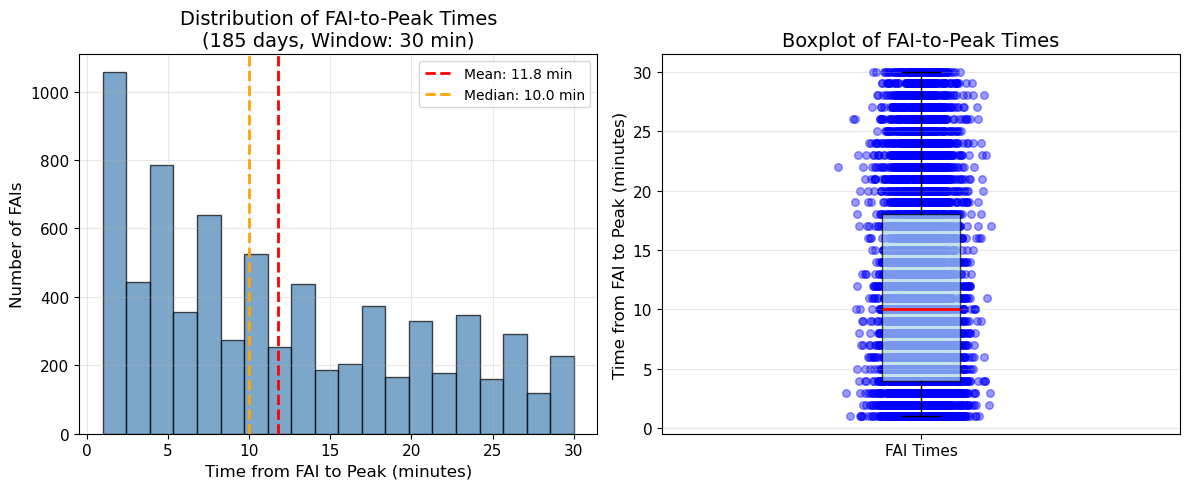

se guardo en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/185d_FAI_to_Peak_Times_Distribution_Window30min.png

=== ESTADÍSTICAS TIEMPOS FAI-to-PEAK ===
Total FAIs asociados: 7355
Tiempo mínimo: 1.0 minutos
Tiempo máximo: 30.0 minutos
Tiempo promedio: 11.8 minutos
Tiempo mediano: 10.0 minutos
Desviación estándar: 8.5 minutos
Percentil 25: 4.0 minutos
Percentil 75: 18.0 minutos


In [45]:
# Uso:
plot_fai_to_peak_times(df_fai_assoc, n_days=n, window_minutes=window_minutes)

## Gráfica de Tiempos por Clase de Flare


In [46]:
def plot_fai_times_by_class(df_fai_assoc, n_days, window_minutes):
    """
    Muestra los tiempos FAI-to-Peak organizados por clase de flare.
    """
    df_associated = df_fai_assoc[
        (df_fai_assoc['Associated_Flare'] == True) & 
        (df_fai_assoc['Time_to_flare'].notna()) &
        (df_fai_assoc['Time_to_flare'] > 0) &
        (df_fai_assoc['F_Class'].notna())
    ].copy()
    
    if len(df_associated) == 0:
        print("No hay datos válidos para graficar")
        return
    
    # Ordenar clases
    class_order = ['A', 'B', 'C', 'M', 'X']
    available_classes = [cls for cls in class_order if cls in df_associated['F_Class'].str[0].unique()]
    
    # Preparar datos para boxplot
    data_by_class = []
    labels = []
    
    for flare_class in available_classes:
        class_times = df_associated[df_associated['F_Class'].str[0] == flare_class]['Time_to_flare']
        if len(class_times) > 0:
            data_by_class.append(class_times)
            labels.append(flare_class)
    
    if not data_by_class:
        print("No hay suficientes datos por clase")
        return
    
    # Gráfica
    plt.figure(figsize=(10, 6))
    
    # Boxplot por clase
    box_plot = plt.boxplot(data_by_class, labels=labels, patch_artist=True, vert=True,
                          boxprops=dict(facecolor='lightblue', alpha=0.7),
                          medianprops=dict(color='red', linewidth=2),
                          whiskerprops=dict(color='black', linewidth=1))
    
    # Añadir puntos individuales con jitter
    for i, class_times in enumerate(data_by_class):
        x_jitter = np.random.normal(i+1, 0.05, size=len(class_times))
        plt.scatter(x_jitter, class_times, alpha=0.5, color='blue', s=40)
    
    plt.xlabel('Flare Class')
    plt.ylabel('Time from FAI to Peak (minutes)')
    plt.title(f'FAI-to-Peak Times by Flare Class\n({n_days} days, Window: {window_minutes} min)', pad=30)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Añadir estadísticas en el gráfico
    for i, class_times in enumerate(data_by_class):
        mean_time = np.mean(class_times)
        count = len(class_times)
        plt.text(i+1, np.max(class_times) + 2, f'n={count}\nμ={mean_time:.1f}', 
                ha='center', va='bottom', fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    
    output_name = f"{n_days}d_FAI_Times_by_Class_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")
    
    # Estadísticas por clase
    print(f"\n=== TIEMPOS POR CLASE DE FLARE ===")
    for i, flare_class in enumerate(labels):
        class_times = data_by_class[i]
        print(f"Clase {flare_class}:")
        print(f"  Count: {len(class_times)}")
        print(f"  Mean: {np.mean(class_times):.1f} min")
        print(f"  Median: {np.median(class_times):.1f} min")
        print(f"  Std: {np.std(class_times):.1f} min")



## Gráfica de Línea de Tiempo de FAIs y Flares

In [47]:
def plot_fai_timeline(df_fai_assoc, n_days, window_minutes, max_display=50):
    """
    Muestra una línea de tiempo con FAIs y sus flares asociados.
    """
    df_associated = df_fai_assoc[
        (df_fai_assoc['Associated_Flare'] == True) & 
        (df_fai_assoc['Time_to_flare'].notna()) &
        (df_fai_assoc['Time_to_flare'] > 0)
    ].copy()
    
    if len(df_associated) == 0:
        print("No hay FAIs asociados para mostrar")
        return
    
    # Ordenar por tiempo FAI y limitar para visualización
    df_associated = df_associated.sort_values('Time_FAI').head(max_display)
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Colores por clase de flare
    class_colors = {'A': 'blue', 'B': 'green', 'C': 'orange', 'M': 'red', 'X': 'purple'}
    
    # Plot cada FAI y su flare asociado
    for idx, row in df_associated.iterrows():
        fai_time = row['Time_FAI']
        flare_time = row['F_PeakTime']
        flare_class = str(row['F_Class'])[0] if pd.notna(row['F_Class']) else 'Unknown'
        time_diff = row['Time_to_flare']
        
        color = class_colors.get(flare_class, 'gray')
        
        # Línea desde FAI hasta flare
        ax.plot([fai_time, flare_time], [idx, idx], 
                color=color, alpha=0.7, linewidth=2)
        
        # Punto FAI
        ax.scatter(fai_time, idx, color='red', s=80, marker='o', 
                  label='FAI' if idx == 0 else "", zorder=5)
        
        # Punto flare
        ax.scatter(flare_time, idx, color=color, s=100, marker='*',
                  label=f'Flare {flare_class}' if idx == 0 else "", zorder=5)
        
        # Etiqueta de tiempo
        ax.text(flare_time, idx + 0.2, f'{time_diff:.1f} min', 
                fontsize=8, ha='center', va='bottom')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('FAI Index')
    ax.set_title(f'FAI-to-Flare Timeline\n({n_days} days, Window: {window_minutes} min)')
    ax.grid(True, alpha=0.3)
    
    # Formatear eje x
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M\n%d/%m'))
    
    # Leyenda
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    plt.tight_layout()
    
    output_name = f"{n_days}d_FAI_Timeline_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")



## gráfica de densidad

In [48]:
def plot_fai_times_density(df_fai_assoc, n_days, window_minutes):
    """
    Gráfica de densidad 2D mostrando la relación entre tiempo y clase.
    """
    df_associated = df_fai_assoc[
        (df_fai_assoc['Associated_Flare'] == True) & 
        (df_fai_assoc['Time_to_flare'].notna()) &
        (df_fai_assoc['Time_to_flare'] > 0) &
        (df_fai_assoc['F_Class'].notna())
    ].copy()
    
    if len(df_associated) == 0:
        return
    
    # Convertir clase a numérico para plotting
    class_mapping = {'A': 1, 'B': 2, 'C': 3, 'M': 4, 'X': 5}
    df_associated['Class_num'] = df_associated['F_Class'].str[0].map(class_mapping)
    
    # Filtrar clases válidas
    df_plot = df_associated[df_associated['Class_num'].notna()]
    
    if len(df_plot) == 0:
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatter plot con densidad de color
    scatter = ax1.scatter(df_plot['Class_num'], df_plot['Time_to_flare'],
                         c=df_plot['Time_to_flare'], cmap='viridis', 
                         alpha=0.6, s=50)
    ax1.set_xlabel('Flare Class')
    ax1.set_ylabel('Time from FAI to Peak (minutes)')
    ax1.set_title('FAI Times vs Flare Class')
    ax1.set_xticks(list(class_mapping.values()))
    ax1.set_xticklabels(list(class_mapping.keys()))
    plt.colorbar(scatter, ax=ax1, label='Time (min)')
    
    # Violin plot
    data_by_class = []
    labels = []
    for flare_class in sorted(df_plot['F_Class'].str[0].unique()):
        class_times = df_plot[df_plot['F_Class'].str[0] == flare_class]['Time_to_flare']
        if len(class_times) > 1:  # violin plot necesita al menos 2 puntos
            data_by_class.append(class_times)
            labels.append(flare_class)
    
    if len(data_by_class) > 1:
        ax2.violinplot(data_by_class, showmeans=True, showmedians=True)
        ax2.set_xticks(range(1, len(labels) + 1))
        ax2.set_xticklabels(labels)
        ax2.set_xlabel('Flare Class')
        ax2.set_ylabel('Time from FAI to Peak (minutes)')
        ax2.set_title('Distribution of FAI Times by Class')
        ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'FAI-to-Peak Time Analysis ({n_days} days, Window: {window_minutes} min)', 
                 fontsize=14)
    plt.tight_layout()
    
    output_name = f"{n_days}d_FAI_Times_Density_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")



## gráfica resumen compacta

In [49]:
def plot_fai_times_summary(df_fai_assoc, n_days, window_minutes):
    """
    Gráfica resumen compacta con múltiples visualizaciones.
    """
    df_associated = df_fai_assoc[
        (df_fai_assoc['Associated_Flare'] == True) & 
        (df_fai_assoc['Time_to_flare'].notna()) &
        (df_fai_assoc['Time_to_flare'] > 0)
    ].copy()
    
    if len(df_associated) == 0:
        print("No hay datos para mostrar")
        return
    
    times = df_associated['Time_to_flare'].values
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Histograma
    ax1.hist(times, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(times), color='red', linestyle='--', label=f'Mean: {np.mean(times):.1f} min')
    ax1.axvline(np.median(times), color='orange', linestyle='--', label=f'Median: {np.median(times):.1f} min')
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of FAI-to-Peak Times')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Boxplot
    ax2.boxplot(times, vert=True)
    ax2.set_ylabel('Time (minutes)')
    ax2.set_title('Boxplot')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Cumulative distribution
    sorted_times = np.sort(times)
    cumulative = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    ax3.plot(sorted_times, cumulative * 100, linewidth=2)
    ax3.set_xlabel('Time (minutes)')
    ax3.set_ylabel('Cumulative Percentage (%)')
    ax3.set_title('Cumulative Distribution')
    ax3.grid(True, alpha=0.3)
    
    # 4. Por percentiles
    percentiles = np.arange(0, 101, 10)
    percentile_values = np.percentile(times, percentiles)
    ax4.bar(percentiles, percentile_values, alpha=0.7, color='lightgreen')
    ax4.set_xlabel('Percentile')
    ax4.set_ylabel('Time (minutes)')
    ax4.set_title('Times by Percentile')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'FAI-to-Peak Times Comprehensive Analysis\n({n_days} days, Window: {window_minutes} min)', 
                 fontsize=16)
    plt.tight_layout()
    
    output_name = f"{n_days}d_FAI_Times_Comprehensive_Window{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"se guardo en: {output_path}")



# pruebas

In [50]:
def plot_fai_flare_dualbar(df_fai_assoc, df_anticipation_time, n_days, window_minutes,
                          column_assoc="Associated_Flare", fai_column="FAIalerts_W"):
    """
    Genera un gráfico con dos barras verticales al 100%:
    - Una para Flares (con/sin FAI)
    - Una para FAIs (asociados/no asociados)
    
    Parameters
    ----------
    df_fai_assoc : DataFrame
        DataFrame con FAIs (debe incluir columna 'Associated_Flare')
    df_anticipation_time : DataFrame
        DataFrame con flares (debe incluir columna FAIalerts_W)
    n_days : int
        Número de días analizados
    window_minutes : int
        Ventana temporal usada para definir la asociación
    column_assoc : str
        Columna booleana en df_fai_assoc que indica si el FAI está asociado a un flare
    fai_column : str
        Columna en df_anticipation_time que indica si el flare tiene FAI
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import os

    # --- Preparar datos de FAIs ---
    fai_assoc_true = df_fai_assoc[column_assoc].sum()
    fai_assoc_false = (~df_fai_assoc[column_assoc]).sum()
    total_fai = fai_assoc_true + fai_assoc_false
    pct_fai_assoc = fai_assoc_true / total_fai * 100
    pct_fai_notassoc = fai_assoc_false / total_fai * 100

    # --- Preparar datos de Flares ---
    if df_anticipation_time[fai_column].dtype in ['int64', 'float64']:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column] > 0
    else:
        df_anticipation_time['FAI_bool'] = df_anticipation_time[fai_column].astype(bool)

    flare_with_fai = df_anticipation_time['FAI_bool'].sum()
    flare_without_fai = (~df_anticipation_time['FAI_bool']).sum()
    total_flare = flare_with_fai + flare_without_fai
    pct_flare_with = flare_with_fai / total_flare * 100
    pct_flare_without = flare_without_fai / total_flare * 100

    # --- Gráfico con espacio para el recuadro de totales ---
    fig, ax = plt.subplots(figsize=(6, 5.5))

    bars = ["Flares", "FAIs"]
    
    # Parte inferior (asociados)
    ax.bar(bars, [pct_flare_with, pct_fai_assoc],
           color='#6BCB77', label='Associated', alpha=0.9, edgecolor='black')

    # Parte superior (no asociados)
    ax.bar(bars, [pct_flare_without, pct_fai_notassoc],
           bottom=[pct_flare_with, pct_fai_assoc],
           color='#FF6B6B', label='Not Associated', alpha=0.9, edgecolor='black')

    # Etiquetas de porcentaje dentro de cada parte
    for i, (with_pct, without_pct) in enumerate(zip([pct_flare_with, pct_fai_assoc],
                                                    [pct_flare_without, pct_fai_notassoc])):
        # Etiqueta para la parte inferior (asociados)
        if with_pct > 5:
            ax.text(i, with_pct / 2, f"{with_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')
        
        # Etiqueta para la parte superior (no asociados)
        if without_pct > 5:
            ax.text(i, with_pct + without_pct / 2, f"{without_pct:.1f}%",
                    ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Ejes y formato
    ax.set_ylim(0, 101)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"FAI–Flare Association Overview\n({n_days} days, Window = {window_minutes} min)",
                pad=20, fontsize=13, fontweight='bold')

    # Leyenda
    legend = ax.legend(title="Association", loc='center left', bbox_to_anchor=(1.02, 0.5),
                      frameon=True, fontsize=11, title_fontsize=12,
                      framealpha=0.9, edgecolor='gray')

    # Recuadro con los totales arriba de la leyenda
    total_text = f"Total Samples:\nFlares: {total_flare}\nFAIs: {total_fai}"
    
    # Crear el recuadro de totales
    props = dict(boxstyle='round', facecolor='lightgray', alpha=0.8, edgecolor='black')
    ax.text(1.12, 0.85, total_text, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.5)

    # Recuadro 2: Parámetros FAI (debajo de la leyenda)
    params_text = f"FAI Parameters:\nT: {fai_temp_range[0]}-{fai_temp_range[1]} MK\nEM > {fai_em_threshold}\nDuration: {FAI_duration} {duration}"
    
    ax.text(1.12, 0.25, params_text, transform=ax.transAxes, fontsize=9,
            fontweight='normal', verticalalignment='top', bbox=props,
            ha='left', linespacing=1.3)


    # Estilo general
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    
    # Ajustar layout para dar espacio al recuadro
    plt.tight_layout(rect=[0, 0, 0.82, 1])

    # Guardar figura
    output_name = f"{n_days}d_FAI_Flare_DualBar_{window_minutes}min.png"
    output_path = os.path.join(graphics_dir, output_name)
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

    print(f"✅ Gráfico guardado en: {output_path}")
    print("\n--- Resumen ---")
    print(f"Total Flares: {total_flare} → {pct_flare_with:.1f}% con FAI, {pct_flare_without:.1f}% sin FAI")
    print(f"Total FAIs: {total_fai} → {pct_fai_assoc:.1f}% asociados, {pct_fai_notassoc:.1f}% no asociados")


    

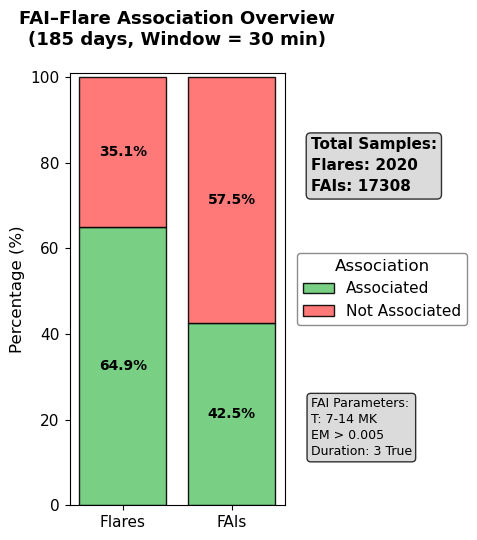

✅ Gráfico guardado en: 2025-11-04_Analysis_for_185_days/GraphicsFAI(W_30)_T7-14_EM0.005_durTrue_3/Graphics_filtered/185d_FAI_Flare_DualBar_30min.png

--- Resumen ---
Total Flares: 2020 → 64.9% con FAI, 35.1% sin FAI
Total FAIs: 17308 → 42.5% asociados, 57.5% no asociados


In [51]:
plot_fai_flare_dualbar(
    df_fai_assoc=df_fai_assoc,
    df_anticipation_time=df_anticipation_time,
    n_days=n,
    window_minutes=window_minutes
)
